In [1]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler
import torchvision.models as models
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import MultiStepLR, ReduceLROnPlateau
#torch.multiprocessing.set_start_method("spawn")
import resnet 
from sklearn.model_selection import KFold

import os
import numpy as np
import pandas as pd
from utils import progress_bar
from skimage import transform as tf

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
BASE_dir = 'data/processed/'

train = pd.read_json(BASE_dir + 'train.json')
test = pd.read_json(BASE_dir + 'test.json')

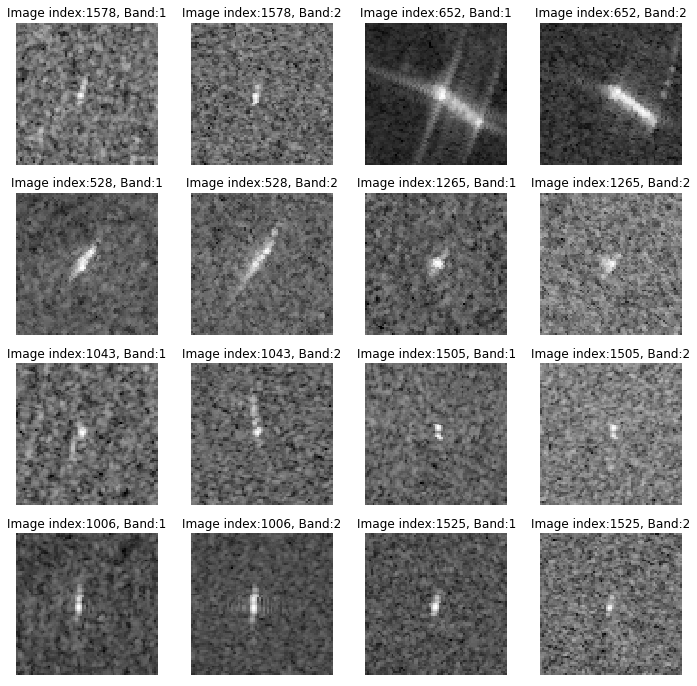

In [3]:
len(train) # 1604 obs
train.head(3)
#randomly draw some of them

fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(4,4)

index = np.random.choice(list(range(len(train))),size=8, replace=False)
for num,i in enumerate(index):
    for j in range(2):
        ax = plt.subplot(gs[num*2+j])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title('Image index:%d, Band:%d' % (i, j%2+1))
        ax.set_aspect('equal')
        plt.imshow(np.array(train.iloc[i,j%2]).reshape(75,75))

In [3]:
#prepare data
use_cuda= True if torch.cuda.is_available() else False
#use_cuda =False
#dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor 
dtype = torch.FloatTensor 
data=  pd.read_json(BASE_dir + 'train.json')

class iceberg_dataset(Dataset):
    def __init__(self, data, label, transform=None, test=False): #data: 1604 * 3 *75* 75
        self.data =data
        self.label = torch.from_numpy(label).type(torch.LongTensor)
        self.transform= transform
        self.test= test
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        img, label=  self.data[idx], self.label[idx]
        if self.transform is not None:
            #Random Horizontal Flip and Vertical Flip 
            #https://discuss.pytorch.org/t/torch-from-numpy-not-support-negative-strides/3663
            
            #rotate, scale, shear, translation
#             if self.test is False:
#                 angle = np.random.uniform(0,360)
#                 img = tf.rotate(img,angle=angle,resize=False)
#                 scale1 = np.exp(np.random.uniform(np.log(1/1.2), np.log(1.2)))
#                 scale2 = np.exp(np.random.uniform(np.log(1/1.2), np.log(1.2)))
#                 #shear = np.random.uniform(-np.pi/18, np.pi/18)
#                 #tran = np.random.uniform(-5, 5)
#                 #aug = tf.AffineTransform(shear = shear, translation=tran, scale= (scale1, scale2))
#                 aug = tf.AffineTransform(scale= (scale1, scale2))
#                 img = tf.warp(img, inverse_map=aug)
            
#                 if np.random.uniform()>0.5:
#                     img = np.flip(img,axis=1).copy()
#                 if np.random.uniform()>0.5:
#                     img = np.flip(img,axis=2).copy()
            
            if self.test is False:
                if np.random.uniform()>0.5:
                    img = np.flip(img,axis=1).copy()
                if np.random.uniform()>0.5:
                    img = np.flip(img,axis=2).copy()
                #scale = np.exp(np.random.uniform(np.log(1/1.1), np.log(1.1)))
                #aug = tf.AffineTransform(scale= (scale, scale))
                #img = tf.warp(img, inverse_map=aug)
#                 angle = np.random.uniform(0,360)
#                 img = tf.rotate(img,angle=angle,resize=False)
#                 angle = np.random.choice([0, 30,60],size=1)
#                 img = tf.rotate(img,angle=angle,resize=False)
                rotate = np.random.randint(4, size=1)
                if rotate:
                    img = np.rot90(img,k=rotate,axes=(1,2)).copy()
            img = torch.from_numpy(img).type(dtype)
            img = self.transform(img)

        return img, label

def stack(row):
    return np.stack(row[['c1','c2','c3']]).reshape(3,75,75)

def raw_to_numpy(data):
    img = []
    data['c1'] = data['band_1'].apply(np.array)
    data['c2'] = data['band_2'].apply(np.array)
    data['c3'] = (data['c1'] + data['c2'])/2
#     data['c3'] = (data['c1'] + data['c2'])/2
    for _, row in data.iterrows():
        img.append(stack(row))
    return np.stack(img)

def transform_compute(img):
    train_mean = img.mean(axis=(0,2,3))
    train_std = img.std(axis=(0,2,3))
    return train_mean, train_std

def data_aug(X, y):
    
    X_rot_30 = []
    X_rot_60 = [] 
    X_h = np.flip(X, 3)
    X_v = np.flip(X, 2)
    for i in X:
        X_rot_30.append(tf.rotate(i,angle=30,resize=False))
        X_rot_60.append(tf.rotate(i,angle=60,resize=False))
        
    X_rot_30 = np.stack(X_rot_30)
    X_rot_60 = np.stack(X_rot_60)
    ch_y = np.concatenate((y,y,y,y,y))
    ch_X = np.concatenate((X, X_h, X_v, X_rot_30, X_rot_60))
    return ch_X, ch_y


train_X = raw_to_numpy(data)#.transpose(0,2,3,1)
train_X.shape     #1604 * 3 *75* 75   N*c*H*W
train_y = data['is_iceberg'].values # if iceberg then 1

In [4]:
# train_index=list(range(1300))
# val_index= list(range(1300,1604))
# train_index=list(range(304,1604)) 
# val_index= list(range(304))
# train_X[train_index].shape
train_index= list(range(1604))
# data.inc_angle = data.inc_angle.map(lambda x: 0.0 if x == 'na' else x)
# train_index = np.where(data.inc_angle > 0)[0]
# val_index = np.where(data.inc_angle <= 0)[0]

# seed= np.random.RandomState(123)
# spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
# train_index, val_index = next(spliter.split(train_X))
train_mean, train_std = transform_compute(train_X[train_index])
train_transform = T.Compose([
    T.Normalize(train_mean, train_std)
])

# train_dataset = iceberg_dataset(data= train_X[train_index], label=train_y[train_index], transform=train_transform)
# val_dataset = iceberg_dataset(data= train_X[val_index], label=train_y[val_index], transform=train_transform, test=True)

# train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
#                           shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)

## add augmentation 

# seed= np.random.RandomState(123)
# spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
# train_index, val_index = next(spliter.split(train_X))

# train_X_af,train_y_af = data_aug(train_X[train_index], train_y[train_index])
# train_mean, train_std = transform_compute(train_X_af)
# train_transform = T.Compose([
#     T.Normalize(train_mean, train_std)
# ])

# train_dataset = iceberg_dataset(data= train_X_af, label=train_y_af, transform=train_transform)
# val_dataset = iceberg_dataset(data= train_X[val_index], label=train_y[val_index], transform=train_transform, test=True)

# train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
#                           shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)


#without na angle data

#data.inc_angle = data.inc_angle.map(lambda x: 0.0 if x == 'na' else x)
# train_X_del = train_X[data.inc_angle!='na',:,:,:]
# train_y_del = train_y[data.inc_angle!='na']
# seed= np.random.RandomState(123)
# spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
# train_index, val_index = next(spliter.split(train_X_del))

# train_mean, train_std = transform_compute(train_X_del[train_index])
# train_transform = T.Compose([
#     T.Normalize(train_mean, train_std)
# ])

# train_dataset = iceberg_dataset(data= np.concatenate((train_X_del[train_index], train_X[np.where(data.inc_angle=='na')[0]])), 
#                                 label= np.concatenate((train_y_del[train_index],train_y[np.where(data.inc_angle=='na')[0]])), transform=train_transform)
# val_dataset = iceberg_dataset(data= train_X_del[val_index], label=train_y_del[val_index], transform=train_transform, test=True)

# train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
#                           shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)

In [84]:
# data.columns
# data.inc_angle!='na'
# data['is_iceberg'][np.where(data.inc_angle=='na')[0]]
# seed= np.random.RandomState(1)
# spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
# train_index, val_index = next(spliter.split(train_X[np.where(data.inc_angle!='na')[0]]))
# train_index
# train_X[np.where(data.inc_angle=='na')[0]].shape

(133, 3, 75, 75)

In [24]:
def train(epoch,early_stopping = None):
    global train_data#,out,y,predicted
    acc=0
    val_loss=0
    best_acc = 0
    best_val_loss= 100
    loss_hist = []
    val_loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    train_data={}
    train_data['loss_hist'] = loss_hist
    train_data['val_loss_hist'] = val_loss_hist
    train_data['train_acc_hist'] = train_acc_hist
    train_data['val_acc_hist'] =  val_acc_hist
    e_s= 0
    best_epoch =0
    
    for i in range(epoch):
        print('\nThis is epoch:{}'.format(i+1))
        total= 0
        correct=0
        loss_avg= 0
        #scheduler.step()
        scheduler.step(acc)
        net.train()
        for j,(batch_x, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()
            if use_cuda:
                batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
            x = Variable(batch_x)
            y = Variable(batch_y)
            out = net(x)
            loss = criterion(out, y)
            loss_avg += loss.cpu().data[0] *out.size()[0]
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(out.data, 1)
            total += y.size(0)
            correct += predicted.eq(y.data).cpu().sum()
            progress_bar(j, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
            if j % 5==0:
                loss_hist.append(loss_avg/total)
            
        train_acc_hist.append(100.*correct/total)
        e_s+=1
        if i %1 == 0:
            acc, val_loss = test(val_loader)
            val_acc_hist.append(acc)
            if acc >=best_acc:
                best_val_loss= val_loss
                best_acc= acc
                e_s = 0
                best_epoch=i
                if val_loss < 0.185 and loss_avg/total < 0.19:#100.*correct/total >92.5:
                    print('save it!\n')
                    torch.save(net.state_dict(), 'resnet34_acc.pth')
            if val_loss < 0.185 and loss_avg/total < 0.185:#100.*correct/total >92.5:
                print('save it!\n')
                torch.save(net.state_dict(), 'resnet34_acc_TEMP.pth')
#                 torch.save(net.state_dict(), 'resnet34_acc.pth')

#             if best_val_loss >= val_loss:
#                 best_val_loss= val_loss
#                 torch.save(net.state_dict(), 'resnet34_loss%d.pth'%i)
        if early_stopping is not None and e_s >= early_stopping:
            return best_val_loss,best_acc,best_epoch

    return best_val_loss,best_acc,best_epoch
#         if i%50==0 and save:
#             torch.save(net.state_dict(), 'resnet50.pth')
        
def test(val_load):
    net.eval()
    total = 0
    correct = 0
    loss_avg= 0
    for k, (val_x, val_y) in enumerate(val_load):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        loss = criterion(out, y)
        loss_avg += loss.cpu().data[0] *out.size()[0]
        #print(out.size())
        _, predicted = torch.max(out.data, 1)
        correct += predicted.eq(y.data).cpu().sum()
        total += out.size()[0]
        progress_bar(k, len(val_load), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
    train_data['val_loss_hist'].append(loss_avg/total) #also keep track of loss of val set
    acc =  (correct*100.0)/total
    return acc,loss_avg/total 

In [87]:
for i in range(20):
    resnet34 = resnet.resnet34(num_classes=2)
    net= resnet34

    criterion = nn.CrossEntropyLoss()

    #Adam does not perform so good here   
    #(0.1, 0.0001) (50, 80, 110, 170) 52 epoch reaches the maximum.
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0002, nesterov= True)
    #scheduler = MultiStepLR(optimizer, [100, 150,200], gamma=0.1)
    scheduler = ReduceLROnPlateau(optimizer, 'max', patience =10,min_lr= 0.0001)
    #5e-3 86
    if use_cuda:
        criterion.cuda()
        net.cuda()
    #     resnet101 = torch.nn.DataParallel(resnet101, device_ids=range(torch.cuda.device_count()))
    #     cudnn.benchmark = True   

    temp = train(epoch=250,early_stopping=15)
    print(temp)
    if temp[0]<0.185 and temp[1]>=93.5:
        break


This is epoch:1
[============ 41/41 ==========>]  Step: 80ms | Tot: 3s314ms | Loss: 0.647 | Acc: 64.629% (846/1309)
[============ 5/5 =======>.....]  Step: 31ms | Tot: 166ms | Loss: 0.772 | Acc: 51.525% (152/295)

This is epoch:2
[============ 41/41 ==========>]  Step: 79ms | Tot: 3s295ms | Loss: 0.548 | Acc: 69.290% (907/1309)
[============ 5/5 =======>.....]  Step: 31ms | Tot: 167ms | Loss: 0.573 | Acc: 69.153% (204/295)

This is epoch:3
[============ 41/41 ==========>]  Step: 79ms | Tot: 3s296ms | Loss: 0.477 | Acc: 76.547% (1002/1309)
[============ 5/5 =======>.....]  Step: 32ms | Tot: 167ms | Loss: 0.336 | Acc: 84.407% (249/295)

This is epoch:4
[============ 41/41 ==========>]  Step: 80ms | Tot: 3s299ms | Loss: 0.393 | Acc: 82.124% (1075/1309)
[============ 5/5 =======>.....]  Step: 31ms | Tot: 165ms | Loss: 0.403 | Acc: 81.017% (239/295)

This is epoch:5
[============ 41/41 ==========>]  Step: 79ms | Tot: 3s299ms | Loss: 0.343 | Acc: 84.645% (1108/1309)
[============ 5/5 ======

[============ 41/41 ==========>]  Step: 80ms | Tot: 3s308ms | Loss: 0.312 | Acc: 88.235% (1155/1309)
[============ 5/5 =======>.....]  Step: 31ms | Tot: 165ms | Loss: 0.383 | Acc: 84.407% (249/295)

This is epoch:9
[============ 41/41 ==========>]  Step: 79ms | Tot: 3s293ms | Loss: 0.300 | Acc: 87.166% (1141/1309)
[============ 5/5 =======>.....]  Step: 31ms | Tot: 166ms | Loss: 0.327 | Acc: 87.797% (259/295)

This is epoch:10
[============ 41/41 ==========>]  Step: 79ms | Tot: 3s298ms | Loss: 0.301 | Acc: 86.860% (1137/1309)
[============ 5/5 =======>.....]  Step: 31ms | Tot: 166ms | Loss: 0.287 | Acc: 85.763% (253/295)

This is epoch:11
[============ 41/41 ==========>]  Step: 79ms | Tot: 3s300ms | Loss: 0.286 | Acc: 87.471% (1145/1309)
[============ 5/5 =======>.....]  Step: 31ms | Tot: 168ms | Loss: 0.241 | Acc: 87.797% (259/295)

This is epoch:12
[============ 41/41 ==========>]  Step: 80ms | Tot: 3s301ms | Loss: 0.253 | Acc: 87.777% (1149/1309)
[============ 5/5 =======>.....]  St

[============ 41/41 ==========>]  Step: 79ms | Tot: 3s294ms | Loss: 0.184 | Acc: 92.590% (1212/1309)
[============ 5/5 =======>.....]  Step: 31ms | Tot: 165ms | Loss: 0.286 | Acc: 90.508% (267/295)

This is epoch:29
[============ 41/41 ==========>]  Step: 79ms | Tot: 3s296ms | Loss: 0.208 | Acc: 91.062% (1192/1309)
[============ 5/5 =======>.....]  Step: 31ms | Tot: 166ms | Loss: 0.277 | Acc: 86.780% (256/295)

This is epoch:30
[============ 41/41 ==========>]  Step: 80ms | Tot: 3s298ms | Loss: 0.188 | Acc: 91.826% (1202/1309)
[============ 5/5 =======>.....]  Step: 31ms | Tot: 165ms | Loss: 0.315 | Acc: 86.102% (254/295)

This is epoch:31
[============ 41/41 ==========>]  Step: 79ms | Tot: 3s304ms | Loss: 0.186 | Acc: 93.888% (1229/1309)
[============ 5/5 =======>.....]  Step: 31ms | Tot: 166ms | Loss: 0.276 | Acc: 87.797% (259/295)

This is epoch:32
[============ 41/41 ==========>]  Step: 80ms | Tot: 3s306ms | Loss: 0.168 | Acc: 93.277% (1221/1309)
[============ 5/5 =======>.....]  S

[============ 41/41 ==========>]  Step: 79ms | Tot: 3s294ms | Loss: 0.187 | Acc: 92.819% (1215/1309)
[============ 5/5 =======>.....]  Step: 32ms | Tot: 167ms | Loss: 0.242 | Acc: 88.136% (260/295)

This is epoch:35
[============ 41/41 ==========>]  Step: 79ms | Tot: 3s299ms | Loss: 0.140 | Acc: 94.270% (1234/1309)
[============ 5/5 =======>.....]  Step: 32ms | Tot: 166ms | Loss: 0.256 | Acc: 90.169% (266/295)

This is epoch:36
[============ 41/41 ==========>]  Step: 79ms | Tot: 3s292ms | Loss: 0.135 | Acc: 94.576% (1238/1309)
[============ 5/5 =======>.....]  Step: 31ms | Tot: 165ms | Loss: 0.355 | Acc: 86.441% (255/295)

This is epoch:37
[============ 41/41 ==========>]  Step: 79ms | Tot: 3s294ms | Loss: 0.136 | Acc: 94.270% (1234/1309)
[============ 5/5 =======>.....]  Step: 32ms | Tot: 168ms | Loss: 0.271 | Acc: 88.814% (262/295)

This is epoch:38
[============ 41/41 ==========>]  Step: 80ms | Tot: 3s296ms | Loss: 0.113 | Acc: 96.180% (1259/1309)
[============ 5/5 =======>.....]  S

[============ 41/41 ==========>]  Step: 80ms | Tot: 3s314ms | Loss: 0.088 | Acc: 96.868% (1268/1309)
[============ 5/5 =======>.....]  Step: 32ms | Tot: 168ms | Loss: 0.323 | Acc: 87.797% (259/295)

This is epoch:42
[============ 41/41 ==========>]  Step: 79ms | Tot: 3s292ms | Loss: 0.070 | Acc: 97.785% (1280/1309)
[============ 5/5 =======>.....]  Step: 31ms | Tot: 168ms | Loss: 0.326 | Acc: 87.458% (258/295)
(0.23569164253392463, 89.15254237288136, 26)

This is epoch:1
[============ 41/41 ==========>]  Step: 79ms | Tot: 3s303ms | Loss: 0.618 | Acc: 64.935% (850/1309)
[============ 5/5 =======>.....]  Step: 31ms | Tot: 166ms | Loss: 1.139 | Acc: 61.017% (180/295)

This is epoch:2
[============ 41/41 ==========>]  Step: 79ms | Tot: 3s297ms | Loss: 0.550 | Acc: 71.123% (931/1309)
[============ 5/5 =======>.....]  Step: 31ms | Tot: 169ms | Loss: 0.470 | Acc: 77.288% (228/295)

This is epoch:3
[============ 41/41 ==========>]  Step: 79ms | Tot: 3s300ms | Loss: 0.399 | Acc: 80.519% (1054/1

Process Process-10187:
KeyboardInterrupt
Process Process-10188:
Process Process-10186:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/usr/local/lib/python3.5/dist-

KeyboardInterrupt: 

In [57]:
seed= np.random.RandomState(7433)
spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
for num, (train_index, val_index) in enumerate(spliter.split(train_X)):
    if num == 4:
        break

train_mean, train_std = transform_compute(train_X[train_index])
train_transform = T.Compose([
    T.Normalize(train_mean, train_std)
])
train_dataset = iceberg_dataset(data= train_X[train_index], label=train_y[train_index], transform=train_transform)
val_dataset = iceberg_dataset(data= train_X[val_index], label=train_y[val_index], transform=train_transform, test=True)

train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
                          shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)

In [5]:
os.listdir('resnet34_save_model')

['resnet34_acc34_2.pth',
 'resnet34_acc21_3.pth',
 'resnet34_acc13_2.pth',
 'resnet34_acc24_2.pth',
 'resnet34_acc24_4.pth',
 'resnet34_acc03_3.pth',
 'resnet34_acc03_4.pth',
 'resnet34_acc24_1.pth',
 'resnet34_acc13_3.pth',
 'resnet34_acc34_4.pth',
 '.ipynb_checkpoints',
 'resnet34_acc34_1.pth',
 'resnet34_acc14_0.pth',
 '1resnet34_acc10_1.pth',
 '1resnet34_acc10_3.pth',
 'resnet34_acc14_4.pth',
 'resnet34_acc54_3.pth',
 'resnet34_acc21_1.pth',
 'resnet34_acc34_3.pth',
 'resnet34_acc13_0.pth',
 'resnet34_acc03_0.pth',
 'resnet34_acc21_0.pth',
 'resnet34_acc13_1.pth']

In [58]:
##For continue training
resnet34 = resnet.resnet34(num_classes=2)
net= resnet34
net.load_state_dict(torch.load('resnet34_save_model/resnet34_acc54_3.pth'))

criterion = nn.CrossEntropyLoss()

#Adam does not perform so good here
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0002, nesterov= True)
#scheduler = MultiStepLR(optimizer, [50,100], gamma=0.1)
scheduler = ReduceLROnPlateau(optimizer, 'max', patience =10,min_lr= 0.0001)
#5e-3 86
if use_cuda:
    criterion.cuda()
    net.cuda()
#     resnet101 = torch.nn.DataParallel(resnet101, device_ids=range(torch.cuda.device_count()))
#     cudnn.benchmark = True   

train(epoch=150)

# test_set = pd.read_json(BASE_dir + 'test.json')
# test_X = raw_to_numpy(test_set)
# test_X.shape 
# fake_label = np.zeros(len(test_X))

# test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform,test=True)

# test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)
# result = []
# for i in range(10):
#     train(epoch=1)

#     prob = [] 
#     net.eval()
#     for k, (val_x, val_y) in enumerate(test_loader):
#         if use_cuda:
#             val_x, val_y = val_x.cuda(), val_y.cuda()
#         x = Variable(val_x)
#         y = Variable(val_y)
#         out = net(x)
#         #prevent overflow
#         temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
#         ans= temp[:,1]/(temp.sum(axis=1))
#         prob.append(ans)
#         #print(out.size())
#         progress_bar(k, len(test_loader))
#     result.append(np.concatenate(prob))


This is epoch:1
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s258ms | Loss: 0.185 | Acc: 92.835% (1192/1284)
[============ 5/5 =======>.....]  Step: 44ms | Tot: 177ms | Loss: 0.157 | Acc: 93.750% (300/320)
save it!

save it!


This is epoch:2
[============ 41/41 ==========>]  Step: 31ms | Tot: 3s252ms | Loss: 0.186 | Acc: 93.069% (1195/1284)
[============ 5/5 =======>.....]  Step: 44ms | Tot: 178ms | Loss: 0.154 | Acc: 95.000% (304/320)

This is epoch:3
[============ 41/41 ==========>]  Step: 31ms | Tot: 3s249ms | Loss: 0.165 | Acc: 94.081% (1208/1284)
[============ 5/5 =======>.....]  Step: 44ms | Tot: 176ms | Loss: 0.151 | Acc: 94.375% (302/320)
save it!


This is epoch:4
[============ 41/41 ==========>]  Step: 31ms | Tot: 3s250ms | Loss: 0.181 | Acc: 93.458% (1200/1284)
[============ 5/5 =======>.....]  Step: 43ms | Tot: 177ms | Loss: 0.156 | Acc: 95.000% (304/320)
save it!

save it!


This is epoch:5
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s246ms | Loss: 0.180

Process Process-2581:
Process Process-2583:
Process Process-2582:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/

KeyboardInterrupt: 

  File "/usr/lib/python3.5/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)


In [75]:
test_set = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test_set)
test_X.shape

(8424, 3, 75, 75)

In [48]:
net = resnet.resnet34(num_classes=2)
net.load_state_dict(torch.load('resnet34_save_model/retrain_resnet34_acc24_2.pth'))
# net.load_state_dict(torch.load('resnet34_acc.pth'))
net.cuda()

test_set = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test_set)
test_X.shape 
fake_label = np.zeros(len(test_X))

test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform)

test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)

prob = [] 
net.eval()
for k, (val_x, val_y) in enumerate(test_loader):
    if use_cuda:
        val_x, val_y = val_x.cuda(), val_y.cuda()
    x = Variable(val_x)
    y = Variable(val_y)
    out = net(x)
    #prevent overflow
    temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
    ans= temp[:,1]/(temp.sum(axis=1))
    prob.append(ans)
    #print(out.size())
    progress_bar(k, len(test_loader))

[============ 132/132 ========>]  Step: 32ms | Tot: 5s819ms


In [31]:
#k =np.stack(result).mean(axis=0)
# #sub.shape
# result[1].shape
# np.concatenate(prob).shape
data['c1'] = data['band_1'].apply(np.array)

In [12]:
sub=pd.DataFrame()
sub['id'] = test['id']
sub['is_iceberg'] = temp12.mean(axis=1)# np.concatenate(prob)
sub.shape
sub.to_csv('submission99.csv',index=False)

In [41]:
temp= pd.read_csv('submission3.csv') #0.0001 wd one
sub['is_iceberg2'] = temp['is_iceberg']
sub.corr()

,is_iceberg,is_iceberg2
is_iceberg,1.000000,0.886197
is_iceberg2,0.886197,1.000000


In [11]:
#try dropout 0.5 on the last fc
resnet34 = resnet.resnet34(num_classes=2)
net= resnet34

criterion = nn.CrossEntropyLoss()

#Adam does not perform so good here   
#(0.1, 0.0001) (50, 80, 110, 170) 52 epoch reaches the maximum.
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001, nesterov= True)
scheduler = MultiStepLR(optimizer, [100, 150,200], gamma=0.1)
#5e-3 86
if use_cuda:
    criterion.cuda()
    net.cuda()
#     resnet101 = torch.nn.DataParallel(resnet101, device_ids=range(torch.cuda.device_count()))
#     cudnn.benchmark = True   

train(epoch=250)


This is epoch:1
[=================== 41/41 =================>.]  Step: 460ms | Tot: 16s242ms | Loss: 4.618 | Acc: 56.231% (731/1300)
[=================== 5/5 ============>........]  Step: 173ms | Tot: 770ms | Loss: 421.466 | Acc: 50.658% (154/304)

This is epoch:2
[=================== 41/41 =================>.]  Step: 464ms | Tot: 16s191ms | Loss: 2.397 | Acc: 59.308% (771/1300)
[=================== 5/5 ============>........]  Step: 174ms | Tot: 767ms | Loss: 1032.273 | Acc: 49.342% (150/304)

This is epoch:3
[=================== 41/41 =================>.]  Step: 463ms | Tot: 16s228ms | Loss: 1.995 | Acc: 58.154% (756/1300)
[=================== 5/5 ============>........]  Step: 173ms | Tot: 766ms | Loss: 522.733 | Acc: 59.539% (181/304)

This is epoch:4
[=================== 41/41 =================>.]  Step: 469ms | Tot: 16s205ms | Loss: 5.970 | Acc: 52.615% (684/1300)
[=================== 5/5 ============>........]  Step: 172ms | Tot: 768ms | Loss: 9.002 | Acc: 50.000% (152/304)

This

[=================== 5/5 ============>........]  Step: 173ms | Tot: 769ms | Loss: 1.166 | Acc: 54.605% (166/304)

This is epoch:66
[=================== 41/41 =================>.]  Step: 463ms | Tot: 16s185ms | Loss: 0.602 | Acc: 65.538% (852/1300)
[=================== 5/5 ============>........]  Step: 172ms | Tot: 837ms | Loss: 0.596 | Acc: 69.079% (210/304)

This is epoch:67
[=================== 41/41 =================>.]  Step: 463ms | Tot: 16s185ms | Loss: 0.594 | Acc: 64.769% (842/1300)
[=================== 5/5 ============>........]  Step: 173ms | Tot: 772ms | Loss: 0.633 | Acc: 63.487% (193/304)

This is epoch:68
[=================== 41/41 =================>.]  Step: 461ms | Tot: 16s184ms | Loss: 0.610 | Acc: 63.308% (823/1300)
[=================== 5/5 ============>........]  Step: 172ms | Tot: 769ms | Loss: 0.650 | Acc: 68.421% (208/304)

This is epoch:69
[=================== 41/41 =================>.]  Step: 466ms | Tot: 16s189ms | Loss: 0.606 | Acc: 65.077% (846/1300)
[=======

[=================== 5/5 ============>........]  Step: 172ms | Tot: 775ms | Loss: 0.245 | Acc: 89.474% (272/304)  Step: 200ms | Tot: 400ms | Loss: 0.246 | Acc: 88.021% (169/192)

This is epoch:129
[=================== 41/41 =================>.]  Step: 464ms | Tot: 16s203ms | Loss: 0.266 | Acc: 87.154% (1133/1300)
[=================== 5/5 ============>........]  Step: 172ms | Tot: 768ms | Loss: 0.238 | Acc: 91.447% (278/304)  Step: 200ms | Tot: 596ms | Loss: 0.224 | Acc: 91.797% (235/256)

This is epoch:130
[=================== 41/41 =================>.]  Step: 462ms | Tot: 16s211ms | Loss: 0.272 | Acc: 87.923% (1143/1300)
[=================== 5/5 ============>........]  Step: 172ms | Tot: 769ms | Loss: 0.230 | Acc: 90.461% (275/304)

This is epoch:131
[=================== 41/41 =================>.]  Step: 461ms | Tot: 16s205ms | Loss: 0.252 | Acc: 88.000% (1144/1300)
[=================== 5/5 ============>........]  Step: 173ms | Tot: 775ms | Loss: 0.231 | Acc: 90.789% (276/304)

This i

[=================== 41/41 =================>.]  Step: 461ms | Tot: 16s195ms | Loss: 0.239 | Acc: 89.385% (1162/1300)
[=================== 5/5 ============>........]  Step: 171ms | Tot: 769ms | Loss: 0.215 | Acc: 91.776% (279/304)

This is epoch:193
[=================== 41/41 =================>.]  Step: 462ms | Tot: 16s206ms | Loss: 0.239 | Acc: 89.846% (1168/1300)
[=================== 5/5 ============>........]  Step: 172ms | Tot: 768ms | Loss: 0.214 | Acc: 92.434% (281/304)

This is epoch:194
[=================== 41/41 =================>.]  Step: 460ms | Tot: 16s207ms | Loss: 0.230 | Acc: 90.231% (1173/1300)
[=================== 5/5 ============>........]  Step: 172ms | Tot: 768ms | Loss: 0.215 | Acc: 91.447% (278/304)

This is epoch:195
[=================== 41/41 =================>.]  Step: 458ms | Tot: 16s180ms | Loss: 0.230 | Acc: 90.385% (1175/1300)
[=================== 5/5 ============>........]  Step: 172ms | Tot: 768ms | Loss: 0.216 | Acc: 91.447% (278/304)

This is epoch:196


(93.42105263157895, 249)

In [35]:
def train(epoch,early_stopping = None):
    global train_data#,out,y,predicted
    acc=0
    val_loss=0
    best_acc = 0
    best_val_loss= 100
    loss_hist = []
    val_loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    train_data={}
    train_data['loss_hist'] = loss_hist
    train_data['val_loss_hist'] = val_loss_hist
    train_data['train_acc_hist'] = train_acc_hist
    train_data['val_acc_hist'] =  val_acc_hist
    e_s= 0
    best_epoch =0
    
    for i in range(epoch):
        print('\nThis is epoch:{}'.format(i+1))
        total= 0
        correct=0
        loss_avg= 0
        #scheduler.step()
        scheduler.step(acc)
        net.train()
        for j,(batch_x, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()
            if use_cuda:
                batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
            x = Variable(batch_x)
            y = Variable(batch_y)
            out = net(x)
            loss = criterion(out, y)
            loss_avg += loss.cpu().data[0] *out.size()[0]
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(out.data, 1)
            total += y.size(0)
            correct += predicted.eq(y.data).cpu().sum()
            progress_bar(j, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
            if j % 5==0:
                loss_hist.append(loss_avg/total)
            
        train_acc_hist.append(100.*correct/total)
        e_s+=1
        if i %1 == 0:
            acc, val_loss = test(val_loader)
            val_acc_hist.append(acc)
            if acc >=best_acc:
                best_train_loss = loss_avg/total
                best_val_loss= val_loss
                best_acc= acc
                e_s = 0
                best_epoch=i
                if val_loss <= 0.195 and 100.*correct/total >92.5:
                    torch.save(net.state_dict(), 'resnet34_acc.pth')

#             if best_val_loss >= val_loss:
#                 best_val_loss= val_loss
#                 torch.save(net.state_dict(), 'resnet34_loss%d.pth'%i)
        if early_stopping is not None and e_s >= early_stopping:
            return best_val_loss,best_acc,best_epoch, best_train_loss

    return best_val_loss,best_acc,best_epoch,best_train_loss
#         if i%50==0 and save:
#             torch.save(net.state_dict(), 'resnet50.pth')
        
def test(val_load):
    net.eval()
    total = 0
    correct = 0
    loss_avg= 0
    for k, (val_x, val_y) in enumerate(val_load):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        loss = criterion(out, y)
        loss_avg += loss.cpu().data[0] *out.size()[0]
        #print(out.size())
        _, predicted = torch.max(out.data, 1)
        correct += predicted.eq(y.data).cpu().sum()
        total += out.size()[0]
        progress_bar(k, len(val_load), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
    train_data['val_loss_hist'].append(loss_avg/total) #also keep track of loss of val set
    acc =  (correct*100.0)/total
    return acc,loss_avg/total 


#Try different transformation

result_hist=[]
for rou in range(6):
    ran_num = np.random.randint(10000,size=1)
    seed= np.random.RandomState(ran_num)
    spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
    for k,(train_index, val_index) in enumerate(spliter.split(train_X)):
        count =0
        train_X[train_index].shape

        train_mean, train_std = transform_compute(train_X[train_index])
        train_transform = T.Compose([
            T.Normalize(train_mean, train_std)
        ])

        train_dataset = iceberg_dataset(data= train_X[train_index], label=train_y[train_index], transform=train_transform)
        val_dataset = iceberg_dataset(data= train_X[val_index], label=train_y[val_index], transform=train_transform, test=True)

        train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
                                  shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)
        for rep in range(6):
            count+=1
            resnet34 = resnet.resnet34(num_classes=2)
            net= resnet34

            criterion = nn.CrossEntropyLoss()

            #Adam does not perform so good here   
            #(0.1, 0.0001) (50, 80, 110, 170) 52 epoch reaches the maximum.
            optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0002, nesterov= True)
            #scheduler = MultiStepLR(optimizer, [100, 150,200], gamma=0.1)
            scheduler = ReduceLROnPlateau(optimizer, 'max', patience =10,min_lr= 0.0001)
            #5e-3 86
            if use_cuda:
                criterion.cuda()
                net.cuda()  

            temp = train(epoch=250,early_stopping=15)
            print(temp)
#             print(temp)
#             if temp[0]<0.185 and temp[1]>=93.5:
#                 break

            #     resnet101 = torch.nn.DataParallel(resnet101, device_ids=range(torch.cuda.device_count()))
            #     cudnn.benchmark = True   
            result_hist.append((rep,temp))
            if  temp[1] >=92.5 and temp[0]<=0.190 and temp[3]<=0.18:
                count=0
                with open("log.txt", "a") as myfile:
                    msg = 'At round {}, fold {}, seed {}, we find a good value with acc: {}, loss: {}\n'.format(rou,
                                                                k,ran_num, temp[1], temp[0])
                    myfile.write(msg)
                cmd = 'cp resnet34_acc.pth resnet34_save_model/1resnet34_acc{}{}_{}.pth'.format(rou,k,rep)
                os.system(cmd)
            if count>=3:
                break


This is epoch:1
[============ 41/41 ==========>]  Step: 41ms | Tot: 3s288ms | Loss: 0.674 | Acc: 64.692% (830/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 194ms | Loss: 6.216 | Acc: 49.221% (158/321)

This is epoch:2
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s268ms | Loss: 0.617 | Acc: 70.226% (901/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 192ms | Loss: 0.495 | Acc: 76.012% (244/321)

This is epoch:3
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s272ms | Loss: 0.457 | Acc: 80.203% (1029/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 193ms | Loss: 0.393 | Acc: 81.931% (263/321)

This is epoch:4
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s253ms | Loss: 0.421 | Acc: 81.606% (1047/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 193ms | Loss: 0.475 | Acc: 78.505% (252/321)

This is epoch:5
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s249ms | Loss: 0.393 | Acc: 82.775% (1062/1283)
[============ 6/6 ======

[============ 41/41 ==========>]  Step: 28ms | Tot: 3s271ms | Loss: 0.256 | Acc: 88.231% (1132/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 193ms | Loss: 0.262 | Acc: 88.785% (285/321)

This is epoch:20
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s270ms | Loss: 0.235 | Acc: 89.867% (1153/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 0.264 | Acc: 88.162% (283/321)

This is epoch:21
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s248ms | Loss: 0.228 | Acc: 90.023% (1155/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 0.282 | Acc: 88.162% (283/321)

This is epoch:22
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s265ms | Loss: 0.234 | Acc: 90.257% (1158/1283)
[============ 6/6 ========>....]  Step: 11ms | Tot: 191ms | Loss: 0.251 | Acc: 88.474% (284/321)

This is epoch:23
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s271ms | Loss: 0.262 | Acc: 89.010% (1142/1283)
[============ 6/6 ========>....]  S

[============ 41/41 ==========>]  Step: 28ms | Tot: 3s254ms | Loss: 0.135 | Acc: 94.544% (1213/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 0.243 | Acc: 91.277% (293/321)

This is epoch:58
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s246ms | Loss: 0.150 | Acc: 93.609% (1201/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 190ms | Loss: 0.242 | Acc: 89.720% (288/321)

This is epoch:59
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s249ms | Loss: 0.150 | Acc: 93.219% (1196/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 192ms | Loss: 0.238 | Acc: 90.654% (291/321)

This is epoch:60
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s254ms | Loss: 0.134 | Acc: 94.154% (1208/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 195ms | Loss: 0.245 | Acc: 90.654% (291/321)

This is epoch:61
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s262ms | Loss: 0.131 | Acc: 94.934% (1218/1283)
[============ 6/6 ========>....]  S

[============ 41/41 ==========>]  Step: 28ms | Tot: 3s244ms | Loss: 0.120 | Acc: 95.246% (1222/1283)
[============ 6/6 ========>....]  Step: 11ms | Tot: 192ms | Loss: 0.252 | Acc: 91.277% (293/321)

This is epoch:96
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s246ms | Loss: 0.121 | Acc: 95.323% (1223/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 191ms | Loss: 0.257 | Acc: 90.966% (292/321)

This is epoch:97
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s245ms | Loss: 0.114 | Acc: 95.791% (1229/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 0.254 | Acc: 91.277% (293/321)

This is epoch:98
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s252ms | Loss: 0.123 | Acc: 95.168% (1221/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 191ms | Loss: 0.257 | Acc: 91.277% (293/321)

This is epoch:99
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s250ms | Loss: 0.119 | Acc: 95.090% (1220/1283)
[============ 6/6 ========>....]  S

[============ 41/41 ==========>]  Step: 28ms | Tot: 3s265ms | Loss: 0.271 | Acc: 87.685% (1125/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 1.604 | Acc: 56.075% (180/321)

This is epoch:22
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s249ms | Loss: 0.357 | Acc: 84.334% (1082/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 192ms | Loss: 0.317 | Acc: 87.539% (281/321)

This is epoch:23
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s253ms | Loss: 0.256 | Acc: 90.101% (1156/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 2.084 | Acc: 54.829% (176/321)

This is epoch:24
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s261ms | Loss: 0.297 | Acc: 88.231% (1132/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 193ms | Loss: 0.391 | Acc: 85.358% (274/321)

This is epoch:25
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s273ms | Loss: 0.239 | Acc: 88.854% (1140/1283)
[============ 6/6 ========>....]  S

[============ 41/41 ==========>]  Step: 29ms | Tot: 3s274ms | Loss: 0.303 | Acc: 86.984% (1116/1283)
[============ 6/6 ========>....]  Step: 11ms | Tot: 194ms | Loss: 4.593 | Acc: 45.794% (147/321)

This is epoch:18
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s272ms | Loss: 0.403 | Acc: 85.035% (1091/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 0.415 | Acc: 84.424% (271/321)

This is epoch:19
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s263ms | Loss: 0.265 | Acc: 88.231% (1132/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 193ms | Loss: 0.479 | Acc: 81.620% (262/321)

This is epoch:20
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s281ms | Loss: 0.301 | Acc: 86.984% (1116/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 193ms | Loss: 0.447 | Acc: 83.801% (269/321)

This is epoch:21
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s283ms | Loss: 0.266 | Acc: 88.620% (1137/1283)
[============ 6/6 ========>....]  S

[============ 41/41 ==========>]  Step: 29ms | Tot: 3s277ms | Loss: 0.478 | Acc: 77.475% (994/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 194ms | Loss: 0.400 | Acc: 80.062% (257/321)

This is epoch:3
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s291ms | Loss: 0.478 | Acc: 78.566% (1008/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 195ms | Loss: 0.671 | Acc: 80.374% (258/321)

This is epoch:4
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s284ms | Loss: 0.384 | Acc: 83.242% (1068/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 193ms | Loss: 3.073 | Acc: 61.371% (197/321)

This is epoch:5
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s271ms | Loss: 0.470 | Acc: 77.475% (994/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 193ms | Loss: 0.375 | Acc: 86.916% (279/321)

This is epoch:6
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s271ms | Loss: 0.359 | Acc: 83.866% (1076/1283)
[============ 6/6 ========>....]  Step: 1

[============ 41/41 ==========>]  Step: 29ms | Tot: 3s260ms | Loss: 0.486 | Acc: 77.708% (997/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 193ms | Loss: 0.433 | Acc: 79.439% (255/321)

This is epoch:12
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s250ms | Loss: 0.370 | Acc: 85.970% (1103/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 0.275 | Acc: 88.162% (283/321)

This is epoch:13
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s233ms | Loss: 0.293 | Acc: 87.451% (1122/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 191ms | Loss: 7.782 | Acc: 46.729% (150/321)

This is epoch:14
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s239ms | Loss: 0.449 | Acc: 84.645% (1086/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 191ms | Loss: 2.321 | Acc: 49.533% (159/321)

This is epoch:15
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s246ms | Loss: 0.360 | Acc: 84.178% (1080/1283)
[============ 6/6 ========>....]  St

[============ 41/41 ==========>]  Step: 30ms | Tot: 3s288ms | Loss: 0.124 | Acc: 95.947% (1231/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 0.308 | Acc: 87.539% (281/321)

This is epoch:60
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s275ms | Loss: 0.113 | Acc: 95.401% (1224/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 193ms | Loss: 0.332 | Acc: 86.604% (278/321)

This is epoch:61
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s273ms | Loss: 0.120 | Acc: 95.947% (1231/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 194ms | Loss: 0.347 | Acc: 86.604% (278/321)

This is epoch:62
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s266ms | Loss: 0.108 | Acc: 96.337% (1236/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 0.334 | Acc: 85.981% (276/321)

This is epoch:63
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s248ms | Loss: 0.106 | Acc: 96.648% (1240/1283)
[============ 6/6 ========>....]  S

[============ 41/41 ==========>]  Step: 29ms | Tot: 3s285ms | Loss: 0.237 | Acc: 89.564% (1150/1284)
[============ 5/5 =======>.....]  Step: 43ms | Tot: 180ms | Loss: 0.206 | Acc: 89.688% (287/320)

This is epoch:24
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s293ms | Loss: 0.218 | Acc: 90.187% (1158/1284)
[============ 5/5 =======>.....]  Step: 44ms | Tot: 179ms | Loss: 0.198 | Acc: 91.875% (294/320)

This is epoch:25
[============ 41/41 ==========>]  Step: 31ms | Tot: 3s299ms | Loss: 0.225 | Acc: 90.732% (1165/1284)
[============ 5/5 =======>.....]  Step: 43ms | Tot: 179ms | Loss: 0.204 | Acc: 92.188% (295/320)

This is epoch:26
[============ 41/41 ==========>]  Step: 31ms | Tot: 3s285ms | Loss: 0.213 | Acc: 90.810% (1166/1284)
[============ 5/5 =======>.....]  Step: 43ms | Tot: 181ms | Loss: 0.212 | Acc: 90.938% (291/320)

This is epoch:27
[============ 41/41 ==========>]  Step: 31ms | Tot: 3s295ms | Loss: 0.211 | Acc: 90.732% (1165/1284)
[============ 5/5 =======>.....]  S

[============ 41/41 ==========>]  Step: 31ms | Tot: 3s268ms | Loss: 0.360 | Acc: 83.645% (1074/1284)
[============ 5/5 =======>.....]  Step: 44ms | Tot: 178ms | Loss: 0.371 | Acc: 84.688% (271/320)

This is epoch:13
[============ 41/41 ==========>]  Step: 31ms | Tot: 3s272ms | Loss: 0.304 | Acc: 86.916% (1116/1284)
[============ 5/5 =======>.....]  Step: 43ms | Tot: 179ms | Loss: 0.678 | Acc: 73.125% (234/320)

This is epoch:14
[============ 41/41 ==========>]  Step: 31ms | Tot: 3s270ms | Loss: 0.288 | Acc: 87.773% (1127/1284)
[============ 5/5 =======>.....]  Step: 42ms | Tot: 176ms | Loss: 1.058 | Acc: 54.062% (173/320)

This is epoch:15
[============ 41/41 ==========>]  Step: 31ms | Tot: 3s258ms | Loss: 0.326 | Acc: 84.813% (1089/1284)
[============ 5/5 =======>.....]  Step: 44ms | Tot: 179ms | Loss: 0.271 | Acc: 87.812% (281/320)

This is epoch:16
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s268ms | Loss: 0.296 | Acc: 87.695% (1126/1284)
[============ 5/5 =======>.....]  S

[============ 41/41 ==========>]  Step: 29ms | Tot: 3s249ms | Loss: 0.174 | Acc: 92.835% (1192/1284)
[============ 5/5 =======>.....]  Step: 43ms | Tot: 179ms | Loss: 0.225 | Acc: 92.812% (297/320)

This is epoch:51
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s265ms | Loss: 0.173 | Acc: 93.224% (1197/1284)
[============ 5/5 =======>.....]  Step: 42ms | Tot: 178ms | Loss: 0.214 | Acc: 91.250% (292/320)

This is epoch:52
[============ 41/41 ==========>]  Step: 31ms | Tot: 3s251ms | Loss: 0.173 | Acc: 92.913% (1193/1284)
[============ 5/5 =======>.....]  Step: 44ms | Tot: 179ms | Loss: 0.206 | Acc: 92.500% (296/320)

This is epoch:53
[============ 41/41 ==========>]  Step: 31ms | Tot: 3s267ms | Loss: 0.160 | Acc: 93.769% (1204/1284)
[============ 5/5 =======>.....]  Step: 42ms | Tot: 180ms | Loss: 0.204 | Acc: 92.500% (296/320)

This is epoch:54
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s270ms | Loss: 0.146 | Acc: 94.548% (1214/1284)
[============ 5/5 =======>.....]  S

[============ 41/41 ==========>]  Step: 29ms | Tot: 3s252ms | Loss: 0.280 | Acc: 88.776% (1139/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 192ms | Loss: 0.259 | Acc: 87.539% (281/321)

This is epoch:28
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s258ms | Loss: 0.257 | Acc: 88.932% (1141/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 193ms | Loss: 0.376 | Acc: 82.866% (266/321)

This is epoch:29
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s257ms | Loss: 0.289 | Acc: 87.607% (1124/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 193ms | Loss: 0.238 | Acc: 89.097% (286/321)

This is epoch:30
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s238ms | Loss: 0.243 | Acc: 89.244% (1145/1283)
[============ 6/6 ========>....]  Step: 14ms | Tot: 194ms | Loss: 0.196 | Acc: 91.900% (295/321)

This is epoch:31
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s261ms | Loss: 0.222 | Acc: 90.725% (1164/1283)
[============ 6/6 ========>....]  S

[============ 41/41 ==========>]  Step: 28ms | Tot: 3s263ms | Loss: 0.212 | Acc: 91.270% (1171/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 0.188 | Acc: 91.589% (294/321)

This is epoch:47
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s266ms | Loss: 0.192 | Acc: 91.348% (1172/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 193ms | Loss: 0.193 | Acc: 90.343% (290/321)

This is epoch:48
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s267ms | Loss: 0.181 | Acc: 92.985% (1193/1283)
[============ 6/6 ========>....]  Step: 11ms | Tot: 192ms | Loss: 0.184 | Acc: 91.277% (293/321)

This is epoch:49
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s269ms | Loss: 0.178 | Acc: 92.362% (1185/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 193ms | Loss: 0.179 | Acc: 92.212% (296/321)

This is epoch:50
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s274ms | Loss: 0.180 | Acc: 92.751% (1190/1283)
[============ 6/6 ========>....]  S

[============ 41/41 ==========>]  Step: 30ms | Tot: 3s278ms | Loss: 0.147 | Acc: 94.232% (1209/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 193ms | Loss: 0.200 | Acc: 90.654% (291/321)

This is epoch:63
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s288ms | Loss: 0.135 | Acc: 94.856% (1217/1283)
[============ 6/6 ========>....]  Step: 14ms | Tot: 196ms | Loss: 0.208 | Acc: 91.589% (294/321)

This is epoch:64
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s279ms | Loss: 0.150 | Acc: 94.310% (1210/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 192ms | Loss: 0.202 | Acc: 91.277% (293/321)

This is epoch:65
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s274ms | Loss: 0.141 | Acc: 95.168% (1221/1283)
[============ 6/6 ========>....]  Step: 14ms | Tot: 194ms | Loss: 0.199 | Acc: 91.277% (293/321)

This is epoch:66
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s273ms | Loss: 0.143 | Acc: 94.778% (1216/1283)
[============ 6/6 ========>....]  S

[============ 41/41 ==========>]  Step: 28ms | Tot: 3s251ms | Loss: 0.277 | Acc: 88.620% (1137/1283)
[============ 6/6 ========>....]  Step: 11ms | Tot: 191ms | Loss: 3.330 | Acc: 55.763% (179/321)

This is epoch:20
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s272ms | Loss: 0.343 | Acc: 85.113% (1092/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 0.262 | Acc: 88.162% (283/321)

This is epoch:21
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s281ms | Loss: 0.258 | Acc: 88.387% (1134/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 192ms | Loss: 0.236 | Acc: 89.720% (288/321)

This is epoch:22
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s280ms | Loss: 0.299 | Acc: 87.763% (1126/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 192ms | Loss: 0.283 | Acc: 90.654% (291/321)

This is epoch:23
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s266ms | Loss: 0.271 | Acc: 88.309% (1133/1283)
[============ 6/6 ========>....]  S

[============ 41/41 ==========>]  Step: 29ms | Tot: 3s265ms | Loss: 0.162 | Acc: 93.453% (1199/1283)
[============ 6/6 ========>....]  Step: 11ms | Tot: 191ms | Loss: 0.223 | Acc: 90.031% (289/321)

This is epoch:58
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s267ms | Loss: 0.168 | Acc: 93.063% (1194/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 0.216 | Acc: 89.720% (288/321)

This is epoch:59
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s259ms | Loss: 0.176 | Acc: 93.141% (1195/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 0.206 | Acc: 91.589% (294/321)

This is epoch:60
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s264ms | Loss: 0.152 | Acc: 93.687% (1202/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 0.208 | Acc: 90.654% (291/321)

This is epoch:61
[============ 41/41 ==========>]  Step: 31ms | Tot: 3s271ms | Loss: 0.160 | Acc: 93.920% (1205/1283)
[============ 6/6 ========>....]  S

[============ 41/41 ==========>]  Step: 29ms | Tot: 3s254ms | Loss: 0.236 | Acc: 89.945% (1154/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 0.284 | Acc: 88.162% (283/321)

This is epoch:27
[============ 41/41 ==========>]  Step: 31ms | Tot: 3s271ms | Loss: 0.230 | Acc: 89.712% (1151/1283)
[============ 6/6 ========>....]  Step: 14ms | Tot: 196ms | Loss: 0.289 | Acc: 88.474% (284/321)

This is epoch:28
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s285ms | Loss: 0.231 | Acc: 89.790% (1152/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 193ms | Loss: 0.300 | Acc: 87.539% (281/321)

This is epoch:29
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s258ms | Loss: 0.220 | Acc: 90.257% (1158/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 194ms | Loss: 0.298 | Acc: 88.162% (283/321)

This is epoch:30
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s261ms | Loss: 0.221 | Acc: 90.413% (1160/1283)
[============ 6/6 ========>....]  S

[============ 41/41 ==========>]  Step: 28ms | Tot: 3s265ms | Loss: 0.178 | Acc: 92.518% (1187/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 0.307 | Acc: 87.850% (282/321)

This is epoch:54
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s247ms | Loss: 0.177 | Acc: 92.751% (1190/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 0.370 | Acc: 85.670% (275/321)

This is epoch:55
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s268ms | Loss: 0.270 | Acc: 87.919% (1128/1283)
[============ 6/6 ========>....]  Step: 11ms | Tot: 193ms | Loss: 0.320 | Acc: 86.293% (277/321)

This is epoch:56
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s260ms | Loss: 0.184 | Acc: 92.985% (1193/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 0.309 | Acc: 86.916% (279/321)

This is epoch:57
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s248ms | Loss: 0.186 | Acc: 92.518% (1187/1283)
[============ 6/6 ========>....]  S

[============ 6/6 ========>....]  Step: 12ms | Tot: 191ms | Loss: 0.290 | Acc: 86.604% (278/321)

This is epoch:16
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s243ms | Loss: 0.232 | Acc: 89.790% (1152/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 190ms | Loss: 2.602 | Acc: 52.336% (168/321)

This is epoch:17
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s257ms | Loss: 0.324 | Acc: 87.919% (1128/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 194ms | Loss: 0.536 | Acc: 79.128% (254/321)

This is epoch:18
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s258ms | Loss: 0.348 | Acc: 85.191% (1093/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 192ms | Loss: 0.499 | Acc: 75.389% (242/321)

This is epoch:19
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s257ms | Loss: 0.292 | Acc: 85.970% (1103/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 194ms | Loss: 0.270 | Acc: 88.474% (284/321)

This is epoch:20
[============ 41/41 =

[============ 41/41 ==========>]  Step: 29ms | Tot: 3s225ms | Loss: 0.189 | Acc: 92.440% (1186/1283)
[============ 6/6 ========>....]  Step: 14ms | Tot: 194ms | Loss: 0.247 | Acc: 90.654% (291/321)

This is epoch:42
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s233ms | Loss: 0.178 | Acc: 92.751% (1190/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 192ms | Loss: 0.248 | Acc: 90.031% (289/321)

This is epoch:43
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s228ms | Loss: 0.186 | Acc: 92.440% (1186/1283)
[============ 6/6 ========>....]  Step: 14ms | Tot: 195ms | Loss: 0.249 | Acc: 90.343% (290/321)

This is epoch:44
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s226ms | Loss: 0.197 | Acc: 92.440% (1186/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 193ms | Loss: 0.243 | Acc: 90.654% (291/321)

This is epoch:45
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s223ms | Loss: 0.173 | Acc: 92.673% (1189/1283)
[============ 6/6 ========>....]  S

[============ 41/41 ==========>]  Step: 29ms | Tot: 3s230ms | Loss: 0.162 | Acc: 93.998% (1206/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 193ms | Loss: 0.230 | Acc: 90.343% (290/321)

This is epoch:63
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s236ms | Loss: 0.163 | Acc: 92.907% (1192/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 193ms | Loss: 0.236 | Acc: 90.654% (291/321)

This is epoch:64
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s251ms | Loss: 0.166 | Acc: 93.453% (1199/1283)
[============ 6/6 ========>....]  Step: 14ms | Tot: 192ms | Loss: 0.230 | Acc: 90.031% (289/321)

This is epoch:65
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s246ms | Loss: 0.158 | Acc: 94.154% (1208/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 194ms | Loss: 0.232 | Acc: 90.966% (292/321)

This is epoch:66
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s234ms | Loss: 0.159 | Acc: 93.687% (1202/1283)
[============ 6/6 ========>....]  S

[============ 41/41 ==========>]  Step: 29ms | Tot: 3s238ms | Loss: 0.608 | Acc: 68.925% (885/1284)
[============ 5/5 =======>.....]  Step: 42ms | Tot: 179ms | Loss: 0.547 | Acc: 69.375% (222/320)

This is epoch:3
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s230ms | Loss: 0.517 | Acc: 74.455% (956/1284)
[============ 5/5 =======>.....]  Step: 43ms | Tot: 177ms | Loss: 0.683 | Acc: 62.500% (200/320)

This is epoch:4
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s228ms | Loss: 0.488 | Acc: 77.726% (998/1284)
[============ 5/5 =======>.....]  Step: 42ms | Tot: 178ms | Loss: 0.372 | Acc: 85.938% (275/320)

This is epoch:5
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s229ms | Loss: 0.388 | Acc: 83.100% (1067/1284)
[============ 5/5 =======>.....]  Step: 43ms | Tot: 177ms | Loss: 4.060 | Acc: 46.875% (150/320)

This is epoch:6
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s236ms | Loss: 0.485 | Acc: 81.231% (1043/1284)
[============ 5/5 =======>.....]  Step: 42

[============ 41/41 ==========>]  Step: 29ms | Tot: 3s241ms | Loss: 0.226 | Acc: 91.667% (1177/1284)
[============ 5/5 =======>.....]  Step: 44ms | Tot: 178ms | Loss: 2.018 | Acc: 60.000% (192/320)

This is epoch:41
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s231ms | Loss: 0.258 | Acc: 90.343% (1160/1284)
[============ 5/5 =======>.....]  Step: 44ms | Tot: 178ms | Loss: 0.384 | Acc: 82.812% (265/320)

This is epoch:42
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s241ms | Loss: 0.176 | Acc: 92.757% (1191/1284)
[============ 5/5 =======>.....]  Step: 44ms | Tot: 179ms | Loss: 0.256 | Acc: 89.688% (287/320)

This is epoch:43
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s232ms | Loss: 0.243 | Acc: 89.486% (1149/1284)
[============ 5/5 =======>.....]  Step: 43ms | Tot: 179ms | Loss: 0.257 | Acc: 87.500% (280/320)

This is epoch:44
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s255ms | Loss: 0.199 | Acc: 91.199% (1171/1284)
[============ 5/5 =======>.....]  S

[============ 41/41 ==========>]  Step: 30ms | Tot: 3s239ms | Loss: 0.159 | Acc: 94.393% (1212/1284)
[============ 5/5 =======>.....]  Step: 43ms | Tot: 178ms | Loss: 0.246 | Acc: 90.938% (291/320)

This is epoch:50
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s252ms | Loss: 0.167 | Acc: 93.614% (1202/1284)
[============ 5/5 =======>.....]  Step: 43ms | Tot: 176ms | Loss: 0.243 | Acc: 92.188% (295/320)

This is epoch:51
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s250ms | Loss: 0.139 | Acc: 94.626% (1215/1284)
[============ 5/5 =======>.....]  Step: 42ms | Tot: 179ms | Loss: 0.241 | Acc: 91.562% (293/320)

This is epoch:52
[============ 41/41 ==========>]  Step: 31ms | Tot: 3s256ms | Loss: 0.146 | Acc: 93.925% (1206/1284)
[============ 5/5 =======>.....]  Step: 42ms | Tot: 179ms | Loss: 0.237 | Acc: 90.625% (290/320)

This is epoch:53
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s246ms | Loss: 0.150 | Acc: 94.081% (1208/1284)
[============ 5/5 =======>.....]  S

[============ 41/41 ==========>]  Step: 31ms | Tot: 3s270ms | Loss: 0.140 | Acc: 94.782% (1217/1284)
[============ 5/5 =======>.....]  Step: 42ms | Tot: 178ms | Loss: 0.248 | Acc: 91.250% (292/320)

This is epoch:88
[============ 41/41 ==========>]  Step: 31ms | Tot: 3s259ms | Loss: 0.140 | Acc: 94.860% (1218/1284)
[============ 5/5 =======>.....]  Step: 42ms | Tot: 179ms | Loss: 0.257 | Acc: 91.250% (292/320)

This is epoch:89
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s257ms | Loss: 0.156 | Acc: 94.003% (1207/1284)
[============ 5/5 =======>.....]  Step: 43ms | Tot: 177ms | Loss: 0.260 | Acc: 90.625% (290/320)

This is epoch:90
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s261ms | Loss: 0.142 | Acc: 94.782% (1217/1284)
[============ 5/5 =======>.....]  Step: 43ms | Tot: 177ms | Loss: 0.234 | Acc: 92.500% (296/320)

This is epoch:91
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s252ms | Loss: 0.134 | Acc: 94.548% (1214/1284)
[============ 5/5 =======>.....]  S

[============ 41/41 ==========>]  Step: 29ms | Tot: 3s267ms | Loss: 0.138 | Acc: 94.782% (1217/1284)
[============ 5/5 =======>.....]  Step: 43ms | Tot: 179ms | Loss: 0.277 | Acc: 89.375% (286/320)

This is epoch:54
[============ 41/41 ==========>]  Step: 31ms | Tot: 3s254ms | Loss: 0.129 | Acc: 94.626% (1215/1284)
[============ 5/5 =======>.....]  Step: 43ms | Tot: 177ms | Loss: 0.263 | Acc: 90.312% (289/320)

This is epoch:55
[============ 41/41 ==========>]  Step: 31ms | Tot: 3s268ms | Loss: 0.125 | Acc: 95.093% (1221/1284)
[============ 5/5 =======>.....]  Step: 42ms | Tot: 179ms | Loss: 0.258 | Acc: 89.688% (287/320)

This is epoch:56
[============ 41/41 ==========>]  Step: 31ms | Tot: 3s262ms | Loss: 0.108 | Acc: 95.950% (1232/1284)
[============ 5/5 =======>.....]  Step: 42ms | Tot: 178ms | Loss: 0.260 | Acc: 90.625% (290/320)
(0.21992684304714202, 91.25, 40, 0.20235671534716526)

This is epoch:1
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s254ms | Loss: 0.700 | Acc: 63

[============ 41/41 ==========>]  Step: 28ms | Tot: 3s226ms | Loss: 0.128 | Acc: 95.246% (1222/1283)
[============ 6/6 ========>....]  Step: 11ms | Tot: 191ms | Loss: 0.240 | Acc: 89.720% (288/321)

This is epoch:73
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s219ms | Loss: 0.139 | Acc: 94.622% (1214/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 190ms | Loss: 0.241 | Acc: 90.031% (289/321)

This is epoch:74
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s254ms | Loss: 0.143 | Acc: 95.012% (1219/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 190ms | Loss: 0.236 | Acc: 90.654% (291/321)
(0.2335223022651078, 91.27725856697819, 58, 0.13498721272261438)

This is epoch:1
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s232ms | Loss: 0.649 | Acc: 63.133% (810/1283)
[============ 6/6 ========>....]  Step: 14ms | Tot: 193ms | Loss: 0.600 | Acc: 56.075% (180/321)

This is epoch:2
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s227ms | Loss: 0.526 

[============ 41/41 ==========>]  Step: 28ms | Tot: 3s229ms | Loss: 0.148 | Acc: 94.700% (1215/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 190ms | Loss: 0.242 | Acc: 89.408% (287/321)

This is epoch:74
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s239ms | Loss: 0.164 | Acc: 93.531% (1200/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 0.242 | Acc: 88.785% (285/321)

This is epoch:75
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s228ms | Loss: 0.152 | Acc: 94.310% (1210/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 193ms | Loss: 0.240 | Acc: 90.031% (289/321)

This is epoch:76
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s227ms | Loss: 0.144 | Acc: 94.154% (1208/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 191ms | Loss: 0.241 | Acc: 88.474% (284/321)

This is epoch:77
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s229ms | Loss: 0.163 | Acc: 93.920% (1205/1283)
[============ 6/6 ========>....]  S

[============ 41/41 ==========>]  Step: 29ms | Tot: 3s283ms | Loss: 0.254 | Acc: 89.790% (1152/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 194ms | Loss: 0.299 | Acc: 87.227% (280/321)

This is epoch:42
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s282ms | Loss: 0.214 | Acc: 90.569% (1162/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 0.256 | Acc: 89.408% (287/321)

This is epoch:43
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s288ms | Loss: 0.203 | Acc: 91.738% (1177/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 193ms | Loss: 0.253 | Acc: 86.916% (279/321)

This is epoch:44
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s288ms | Loss: 0.212 | Acc: 92.128% (1182/1283)
[============ 6/6 ========>....]  Step: 11ms | Tot: 192ms | Loss: 0.250 | Acc: 88.785% (285/321)

This is epoch:45
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s288ms | Loss: 0.190 | Acc: 92.284% (1184/1283)
[============ 6/6 ========>....]  S

[============ 6/6 ========>....]  Step: 12ms | Tot: 193ms | Loss: 0.312 | Acc: 84.735% (272/321)

This is epoch:19
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s267ms | Loss: 0.219 | Acc: 91.504% (1174/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 190ms | Loss: 0.316 | Acc: 86.293% (277/321)

This is epoch:20
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s273ms | Loss: 0.220 | Acc: 91.660% (1176/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 193ms | Loss: 0.356 | Acc: 85.047% (273/321)

This is epoch:21
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s262ms | Loss: 0.232 | Acc: 90.413% (1160/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 194ms | Loss: 0.296 | Acc: 86.293% (277/321)

This is epoch:22
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s256ms | Loss: 0.208 | Acc: 91.894% (1179/1283)
[============ 6/6 ========>....]  Step: 11ms | Tot: 192ms | Loss: 0.291 | Acc: 87.850% (282/321)

This is epoch:23
[============ 41/41 =

[============ 6/6 ========>....]  Step: 12ms | Tot: 193ms | Loss: 0.366 | Acc: 86.604% (278/321)

This is epoch:27
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s243ms | Loss: 0.258 | Acc: 89.166% (1144/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 0.301 | Acc: 89.097% (286/321)

This is epoch:28
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s238ms | Loss: 0.247 | Acc: 88.776% (1139/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 193ms | Loss: 0.466 | Acc: 83.489% (268/321)

This is epoch:29
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s244ms | Loss: 0.249 | Acc: 89.556% (1149/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 194ms | Loss: 0.273 | Acc: 90.966% (292/321)

This is epoch:30
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s242ms | Loss: 0.229 | Acc: 89.712% (1151/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 0.321 | Acc: 89.408% (287/321)

This is epoch:31
[============ 41/41 =

[============ 41/41 ==========>]  Step: 28ms | Tot: 3s242ms | Loss: 0.177 | Acc: 92.829% (1191/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 0.210 | Acc: 90.966% (292/321)

This is epoch:50
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s253ms | Loss: 0.175 | Acc: 92.829% (1191/1283)
[============ 6/6 ========>....]  Step: 11ms | Tot: 190ms | Loss: 0.205 | Acc: 91.900% (295/321)

This is epoch:51
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s241ms | Loss: 0.174 | Acc: 93.531% (1200/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 194ms | Loss: 0.211 | Acc: 90.966% (292/321)

This is epoch:52
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s235ms | Loss: 0.180 | Acc: 92.829% (1191/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 0.210 | Acc: 91.900% (295/321)

This is epoch:53
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s238ms | Loss: 0.175 | Acc: 93.297% (1197/1283)
[============ 6/6 ========>....]  S

[============ 41/41 ==========>]  Step: 29ms | Tot: 3s268ms | Loss: 0.218 | Acc: 90.803% (1165/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 193ms | Loss: 0.196 | Acc: 92.835% (298/321)

This is epoch:72
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s260ms | Loss: 0.220 | Acc: 91.270% (1171/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 193ms | Loss: 0.199 | Acc: 93.769% (301/321)

This is epoch:73
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s238ms | Loss: 0.216 | Acc: 91.115% (1169/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 0.196 | Acc: 92.835% (298/321)

This is epoch:74
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s236ms | Loss: 0.212 | Acc: 91.426% (1173/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 191ms | Loss: 0.195 | Acc: 92.212% (296/321)

This is epoch:75
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s260ms | Loss: 0.212 | Acc: 92.050% (1181/1283)
[============ 6/6 ========>....]  S

[============ 41/41 ==========>]  Step: 30ms | Tot: 3s295ms | Loss: 0.324 | Acc: 85.425% (1096/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 194ms | Loss: 0.308 | Acc: 87.227% (280/321)

This is epoch:16
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s289ms | Loss: 0.286 | Acc: 86.594% (1111/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 193ms | Loss: 0.307 | Acc: 85.047% (273/321)

This is epoch:17
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s250ms | Loss: 0.290 | Acc: 87.997% (1129/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 0.313 | Acc: 87.539% (281/321)

This is epoch:18
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s251ms | Loss: 0.280 | Acc: 87.607% (1124/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 194ms | Loss: 0.232 | Acc: 89.720% (288/321)

This is epoch:19
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s247ms | Loss: 0.262 | Acc: 88.387% (1134/1283)
[============ 6/6 ========>....]  S

[============ 41/41 ==========>]  Step: 29ms | Tot: 3s261ms | Loss: 0.230 | Acc: 89.322% (1146/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 191ms | Loss: 0.210 | Acc: 92.212% (296/321)

This is epoch:54
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s251ms | Loss: 0.225 | Acc: 90.881% (1166/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 193ms | Loss: 0.207 | Acc: 92.523% (297/321)

This is epoch:55
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s271ms | Loss: 0.214 | Acc: 91.193% (1170/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 193ms | Loss: 0.216 | Acc: 90.966% (292/321)

This is epoch:56
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s269ms | Loss: 0.220 | Acc: 91.270% (1171/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 191ms | Loss: 0.208 | Acc: 90.966% (292/321)

This is epoch:57
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s260ms | Loss: 0.222 | Acc: 91.582% (1175/1283)
[============ 6/6 ========>....]  S

[============ 41/41 ==========>]  Step: 30ms | Tot: 3s244ms | Loss: 0.158 | Acc: 92.835% (1192/1284)
[============ 5/5 =======>.....]  Step: 42ms | Tot: 176ms | Loss: 0.267 | Acc: 89.375% (286/320)

This is epoch:60
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s237ms | Loss: 0.144 | Acc: 94.393% (1212/1284)
[============ 5/5 =======>.....]  Step: 44ms | Tot: 179ms | Loss: 0.257 | Acc: 90.000% (288/320)

This is epoch:61
[============ 41/41 ==========>]  Step: 31ms | Tot: 3s251ms | Loss: 0.146 | Acc: 94.470% (1213/1284)
[============ 5/5 =======>.....]  Step: 43ms | Tot: 177ms | Loss: 0.249 | Acc: 90.312% (289/320)

This is epoch:62
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s254ms | Loss: 0.158 | Acc: 93.536% (1201/1284)
[============ 5/5 =======>.....]  Step: 42ms | Tot: 177ms | Loss: 0.251 | Acc: 90.312% (289/320)

This is epoch:63
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s247ms | Loss: 0.139 | Acc: 95.405% (1225/1284)
[============ 5/5 =======>.....]  S

[============ 41/41 ==========>]  Step: 31ms | Tot: 3s271ms | Loss: 0.918 | Acc: 66.355% (852/1284)
[============ 5/5 =======>.....]  Step: 43ms | Tot: 179ms | Loss: 0.640 | Acc: 69.375% (222/320)

This is epoch:3
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s271ms | Loss: 0.498 | Acc: 77.804% (999/1284)
[============ 5/5 =======>.....]  Step: 43ms | Tot: 179ms | Loss: 0.949 | Acc: 45.938% (147/320)

This is epoch:4
[============ 41/41 ==========>]  Step: 31ms | Tot: 3s254ms | Loss: 0.481 | Acc: 78.193% (1004/1284)
[============ 5/5 =======>.....]  Step: 42ms | Tot: 179ms | Loss: 0.418 | Acc: 80.000% (256/320)

This is epoch:5
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s249ms | Loss: 0.376 | Acc: 83.178% (1068/1284)
[============ 5/5 =======>.....]  Step: 42ms | Tot: 176ms | Loss: 0.394 | Acc: 82.188% (263/320)

This is epoch:6
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s249ms | Loss: 0.354 | Acc: 84.346% (1083/1284)
[============ 5/5 =======>.....]  Step: 4

[============ 41/41 ==========>]  Step: 28ms | Tot: 3s247ms | Loss: 0.207 | Acc: 92.518% (1187/1283)
[============ 6/6 ========>....]  Step: 11ms | Tot: 191ms | Loss: 0.214 | Acc: 90.031% (289/321)

This is epoch:44
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s253ms | Loss: 0.204 | Acc: 92.362% (1185/1283)
[============ 6/6 ========>....]  Step: 14ms | Tot: 196ms | Loss: 0.201 | Acc: 90.966% (292/321)

This is epoch:45
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s278ms | Loss: 0.203 | Acc: 91.738% (1177/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 194ms | Loss: 0.207 | Acc: 89.720% (288/321)

This is epoch:46
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s269ms | Loss: 0.207 | Acc: 91.894% (1179/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 191ms | Loss: 0.198 | Acc: 91.589% (294/321)

This is epoch:47
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s251ms | Loss: 0.200 | Acc: 91.972% (1180/1283)
[============ 6/6 ========>....]  S

[============ 41/41 ==========>]  Step: 29ms | Tot: 3s270ms | Loss: 0.194 | Acc: 92.518% (1187/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 0.190 | Acc: 91.589% (294/321)

This is epoch:82
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s271ms | Loss: 0.188 | Acc: 92.907% (1192/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 191ms | Loss: 0.192 | Acc: 90.966% (292/321)

This is epoch:83
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s248ms | Loss: 0.179 | Acc: 92.518% (1187/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 192ms | Loss: 0.190 | Acc: 91.589% (294/321)

This is epoch:84
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s252ms | Loss: 0.194 | Acc: 92.907% (1192/1283)
[============ 6/6 ========>....]  Step: 11ms | Tot: 190ms | Loss: 0.188 | Acc: 91.900% (295/321)

This is epoch:85
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s271ms | Loss: 0.201 | Acc: 91.816% (1178/1283)
[============ 6/6 ========>....]  S

[============ 41/41 ==========>]  Step: 29ms | Tot: 3s288ms | Loss: 0.707 | Acc: 71.317% (915/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 195ms | Loss: 0.496 | Acc: 74.455% (239/321)

This is epoch:16
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s277ms | Loss: 0.484 | Acc: 76.773% (985/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 193ms | Loss: 0.427 | Acc: 77.259% (248/321)

This is epoch:17
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s270ms | Loss: 0.461 | Acc: 77.007% (988/1283)
[============ 6/6 ========>....]  Step: 11ms | Tot: 193ms | Loss: 0.411 | Acc: 78.816% (253/321)

This is epoch:18
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s282ms | Loss: 0.422 | Acc: 79.891% (1025/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 194ms | Loss: 0.411 | Acc: 78.505% (252/321)
(0.3888646494191012, 82.86604361370716, 2, 0.48966347901782115)

This is epoch:1
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s292ms | Loss: 0.657 | 

[============ 41/41 ==========>]  Step: 29ms | Tot: 3s287ms | Loss: 0.149 | Acc: 94.388% (1211/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 193ms | Loss: 0.279 | Acc: 89.408% (287/321)
(0.30005573186547585, 90.65420560747664, 56, 0.17718440791358264)

This is epoch:1
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s284ms | Loss: 0.661 | Acc: 65.627% (842/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 193ms | Loss: 1.728 | Acc: 58.255% (187/321)

This is epoch:2
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s270ms | Loss: 0.496 | Acc: 74.747% (959/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 192ms | Loss: 0.575 | Acc: 67.913% (218/321)

This is epoch:3
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s259ms | Loss: 0.455 | Acc: 77.708% (997/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 191ms | Loss: 0.509 | Acc: 71.651% (230/321)

This is epoch:4
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s250ms | Loss: 0.391 | A

[============ 41/41 ==========>]  Step: 29ms | Tot: 3s242ms | Loss: 0.468 | Acc: 77.786% (998/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 193ms | Loss: 1.162 | Acc: 45.794% (147/321)

This is epoch:45
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s240ms | Loss: 0.438 | Acc: 80.904% (1038/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 194ms | Loss: 0.502 | Acc: 74.455% (239/321)

This is epoch:46
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s246ms | Loss: 0.475 | Acc: 75.838% (973/1283)
[============ 6/6 ========>....]  Step: 11ms | Tot: 192ms | Loss: 0.450 | Acc: 74.455% (239/321)

This is epoch:47
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s238ms | Loss: 0.379 | Acc: 82.697% (1061/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 194ms | Loss: 0.383 | Acc: 79.751% (256/321)

This is epoch:48
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s241ms | Loss: 0.358 | Acc: 82.307% (1056/1283)
[============ 6/6 ========>....]  Ste

[============ 41/41 ==========>]  Step: 31ms | Tot: 3s258ms | Loss: 0.264 | Acc: 89.790% (1152/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 195ms | Loss: 0.265 | Acc: 89.408% (287/321)

This is epoch:33
[============ 41/41 ==========>]  Step: 31ms | Tot: 3s253ms | Loss: 0.255 | Acc: 90.413% (1160/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 193ms | Loss: 0.235 | Acc: 88.474% (284/321)

This is epoch:34
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s255ms | Loss: 0.214 | Acc: 90.647% (1163/1283)
[============ 6/6 ========>....]  Step: 14ms | Tot: 196ms | Loss: 0.231 | Acc: 88.785% (285/321)

This is epoch:35
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s256ms | Loss: 0.203 | Acc: 91.115% (1169/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 195ms | Loss: 0.219 | Acc: 90.654% (291/321)

This is epoch:36
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s253ms | Loss: 0.203 | Acc: 91.894% (1179/1283)
[============ 6/6 ========>....]  S

[============ 41/41 ==========>]  Step: 29ms | Tot: 3s251ms | Loss: 0.314 | Acc: 86.204% (1106/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 193ms | Loss: 0.312 | Acc: 85.047% (273/321)

This is epoch:16
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s243ms | Loss: 0.295 | Acc: 86.906% (1115/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 197ms | Loss: 0.460 | Acc: 81.308% (261/321)

This is epoch:17
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s241ms | Loss: 0.341 | Acc: 84.801% (1088/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 195ms | Loss: 0.313 | Acc: 85.047% (273/321)

This is epoch:18
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s252ms | Loss: 0.289 | Acc: 85.892% (1102/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 194ms | Loss: 0.600 | Acc: 70.093% (225/321)

This is epoch:19
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s251ms | Loss: 0.277 | Acc: 87.607% (1124/1283)
[============ 6/6 ========>....]  S

[============ 41/41 ==========>]  Step: 28ms | Tot: 3s229ms | Loss: 0.167 | Acc: 93.141% (1195/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 191ms | Loss: 0.233 | Acc: 90.966% (292/321)

This is epoch:54
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s233ms | Loss: 0.180 | Acc: 92.829% (1191/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 193ms | Loss: 0.225 | Acc: 90.654% (291/321)

This is epoch:55
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s232ms | Loss: 0.193 | Acc: 92.751% (1190/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 194ms | Loss: 0.227 | Acc: 91.589% (294/321)

This is epoch:56
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s237ms | Loss: 0.171 | Acc: 94.154% (1208/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 0.234 | Acc: 90.966% (292/321)

This is epoch:57
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s244ms | Loss: 0.175 | Acc: 92.751% (1190/1283)
[============ 6/6 ========>....]  S

[============ 41/41 ==========>]  Step: 29ms | Tot: 3s263ms | Loss: 0.348 | Acc: 85.425% (1096/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 194ms | Loss: 10.237 | Acc: 52.025% (167/321)

This is epoch:6
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s276ms | Loss: 0.549 | Acc: 73.733% (946/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 196ms | Loss: 6.580 | Acc: 49.221% (158/321)

This is epoch:7
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s282ms | Loss: 0.949 | Acc: 72.486% (930/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 195ms | Loss: 0.492 | Acc: 74.766% (240/321)

This is epoch:8
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s264ms | Loss: 0.429 | Acc: 79.034% (1014/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 198ms | Loss: 0.596 | Acc: 61.371% (197/321)

This is epoch:9
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s272ms | Loss: 0.387 | Acc: 83.009% (1065/1283)
[============ 6/6 ========>....]  Step: 

[============ 41/41 ==========>]  Step: 28ms | Tot: 3s235ms | Loss: 0.191 | Acc: 92.595% (1188/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 193ms | Loss: 0.277 | Acc: 88.474% (284/321)

This is epoch:44
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s237ms | Loss: 0.182 | Acc: 93.141% (1195/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 193ms | Loss: 0.274 | Acc: 88.162% (283/321)

This is epoch:45
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s261ms | Loss: 0.166 | Acc: 93.998% (1206/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 195ms | Loss: 0.252 | Acc: 90.966% (292/321)

This is epoch:46
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s253ms | Loss: 0.175 | Acc: 93.219% (1196/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 195ms | Loss: 0.270 | Acc: 88.785% (285/321)

This is epoch:47
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s274ms | Loss: 0.164 | Acc: 93.453% (1199/1283)
[============ 6/6 ========>....]  S

[============ 41/41 ==========>]  Step: 31ms | Tot: 3s257ms | Loss: 0.591 | Acc: 76.090% (977/1284)
[============ 5/5 =======>.....]  Step: 44ms | Tot: 181ms | Loss: 0.920 | Acc: 58.750% (188/320)

This is epoch:12
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s259ms | Loss: 0.519 | Acc: 75.234% (966/1284)
[============ 5/5 =======>.....]  Step: 44ms | Tot: 180ms | Loss: 0.673 | Acc: 70.312% (225/320)

This is epoch:13
[============ 41/41 ==========>]  Step: 31ms | Tot: 3s260ms | Loss: 0.431 | Acc: 80.218% (1030/1284)
[============ 5/5 =======>.....]  Step: 42ms | Tot: 180ms | Loss: 3.768 | Acc: 51.875% (166/320)

This is epoch:14
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s262ms | Loss: 0.547 | Acc: 78.193% (1004/1284)
[============ 5/5 =======>.....]  Step: 44ms | Tot: 181ms | Loss: 0.482 | Acc: 78.125% (250/320)

This is epoch:15
[============ 41/41 ==========>]  Step: 31ms | Tot: 3s291ms | Loss: 0.371 | Acc: 83.178% (1068/1284)
[============ 5/5 =======>.....]  Ste

[============ 41/41 ==========>]  Step: 31ms | Tot: 3s278ms | Loss: 0.190 | Acc: 91.667% (1177/1284)
[============ 5/5 =======>.....]  Step: 42ms | Tot: 180ms | Loss: 0.324 | Acc: 88.750% (284/320)

This is epoch:50
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s282ms | Loss: 0.177 | Acc: 93.380% (1199/1284)
[============ 5/5 =======>.....]  Step: 43ms | Tot: 181ms | Loss: 1.214 | Acc: 62.188% (199/320)

This is epoch:51
[============ 41/41 ==========>]  Step: 31ms | Tot: 3s291ms | Loss: 0.334 | Acc: 86.682% (1113/1284)
[============ 5/5 =======>.....]  Step: 43ms | Tot: 182ms | Loss: 0.494 | Acc: 72.188% (231/320)

This is epoch:52
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s287ms | Loss: 0.397 | Acc: 81.386% (1045/1284)
[============ 5/5 =======>.....]  Step: 44ms | Tot: 181ms | Loss: 0.422 | Acc: 83.125% (266/320)

This is epoch:53
[============ 41/41 ==========>]  Step: 31ms | Tot: 3s252ms | Loss: 0.310 | Acc: 86.293% (1108/1284)
[============ 5/5 =======>.....]  S

[============ 41/41 ==========>]  Step: 29ms | Tot: 3s260ms | Loss: 0.276 | Acc: 86.906% (1115/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 196ms | Loss: 0.232 | Acc: 89.097% (286/321)

This is epoch:23
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s269ms | Loss: 0.262 | Acc: 87.997% (1129/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 193ms | Loss: 0.344 | Acc: 85.358% (274/321)

This is epoch:24
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s248ms | Loss: 0.272 | Acc: 87.217% (1119/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 195ms | Loss: 0.220 | Acc: 91.589% (294/321)

This is epoch:25
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s246ms | Loss: 0.256 | Acc: 89.166% (1144/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 194ms | Loss: 0.201 | Acc: 92.212% (296/321)

This is epoch:26
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s253ms | Loss: 0.253 | Acc: 87.685% (1125/1283)
[============ 6/6 ========>....]  S

[============ 41/41 ==========>]  Step: 28ms | Tot: 3s253ms | Loss: 0.267 | Acc: 88.854% (1140/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 197ms | Loss: 0.769 | Acc: 67.290% (216/321)

This is epoch:46
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s298ms | Loss: 0.248 | Acc: 89.400% (1147/1283)
[============ 6/6 ========>....]  Step: 14ms | Tot: 197ms | Loss: 0.205 | Acc: 91.589% (294/321)

This is epoch:47
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s286ms | Loss: 0.240 | Acc: 90.179% (1157/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 198ms | Loss: 0.202 | Acc: 92.835% (298/321)

This is epoch:48
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s252ms | Loss: 0.184 | Acc: 92.518% (1187/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 193ms | Loss: 0.195 | Acc: 92.523% (297/321)

This is epoch:49
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s272ms | Loss: 0.205 | Acc: 91.426% (1173/1283)
[============ 6/6 ========>....]  S

[============ 41/41 ==========>]  Step: 30ms | Tot: 3s259ms | Loss: 0.236 | Acc: 89.790% (1152/1283)
[============ 6/6 ========>....]  Step: 11ms | Tot: 193ms | Loss: 0.227 | Acc: 91.589% (294/321)

This is epoch:57
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s254ms | Loss: 0.233 | Acc: 89.556% (1149/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 194ms | Loss: 0.245 | Acc: 90.343% (290/321)

This is epoch:58
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s261ms | Loss: 0.231 | Acc: 89.712% (1151/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 195ms | Loss: 0.214 | Acc: 93.146% (299/321)

This is epoch:59
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s257ms | Loss: 0.224 | Acc: 90.335% (1159/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 195ms | Loss: 0.207 | Acc: 92.835% (298/321)

This is epoch:60
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s249ms | Loss: 0.228 | Acc: 90.881% (1166/1283)
[============ 6/6 ========>....]  S

[============ 41/41 ==========>]  Step: 30ms | Tot: 3s257ms | Loss: 0.737 | Acc: 64.614% (829/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 194ms | Loss: 1.691 | Acc: 47.664% (153/321)

This is epoch:6
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s254ms | Loss: 0.541 | Acc: 71.863% (922/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 195ms | Loss: 0.532 | Acc: 75.701% (243/321)

This is epoch:7
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s250ms | Loss: 0.441 | Acc: 80.514% (1033/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 193ms | Loss: 2.542 | Acc: 47.664% (153/321)

This is epoch:8
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s282ms | Loss: 0.483 | Acc: 74.747% (959/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 195ms | Loss: 0.563 | Acc: 73.832% (237/321)

This is epoch:9
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s282ms | Loss: 0.380 | Acc: 83.944% (1077/1283)
[============ 6/6 ========>....]  Step: 13

[============ 41/41 ==========>]  Step: 29ms | Tot: 3s281ms | Loss: 0.293 | Acc: 86.594% (1111/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 194ms | Loss: 0.318 | Acc: 88.474% (284/321)

This is epoch:44
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s253ms | Loss: 0.253 | Acc: 89.478% (1148/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 194ms | Loss: 0.786 | Acc: 66.667% (214/321)

This is epoch:45
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s249ms | Loss: 0.220 | Acc: 90.335% (1159/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 195ms | Loss: 0.332 | Acc: 85.670% (275/321)

This is epoch:46
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s240ms | Loss: 0.211 | Acc: 91.115% (1169/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 196ms | Loss: 0.320 | Acc: 86.916% (279/321)

This is epoch:47
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s254ms | Loss: 0.193 | Acc: 91.115% (1169/1283)
[============ 6/6 ========>....]  S

[============ 41/41 ==========>]  Step: 30ms | Tot: 3s251ms | Loss: 0.429 | Acc: 80.592% (1034/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 192ms | Loss: 0.384 | Acc: 80.997% (260/321)

This is epoch:11
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s257ms | Loss: 0.356 | Acc: 83.087% (1066/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 196ms | Loss: 0.487 | Acc: 74.455% (239/321)

This is epoch:12
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s252ms | Loss: 0.361 | Acc: 83.710% (1074/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 192ms | Loss: 0.396 | Acc: 83.178% (267/321)

This is epoch:13
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s251ms | Loss: 0.313 | Acc: 86.516% (1110/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 196ms | Loss: 3.154 | Acc: 48.598% (156/321)

This is epoch:14
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s259ms | Loss: 0.367 | Acc: 85.503% (1097/1283)
[============ 6/6 ========>....]  S

[============ 41/41 ==========>]  Step: 30ms | Tot: 3s249ms | Loss: 0.186 | Acc: 92.050% (1181/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 194ms | Loss: 0.234 | Acc: 89.720% (288/321)

This is epoch:49
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s262ms | Loss: 0.192 | Acc: 91.738% (1177/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 195ms | Loss: 0.232 | Acc: 88.162% (283/321)

This is epoch:50
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s276ms | Loss: 0.180 | Acc: 92.829% (1191/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 195ms | Loss: 0.231 | Acc: 89.408% (287/321)

This is epoch:51
[============ 41/41 ==========>]  Step: 31ms | Tot: 3s273ms | Loss: 0.183 | Acc: 91.972% (1180/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 193ms | Loss: 0.230 | Acc: 89.720% (288/321)

This is epoch:52
[============ 41/41 ==========>]  Step: 31ms | Tot: 3s278ms | Loss: 0.183 | Acc: 92.751% (1190/1283)
[============ 6/6 ========>....]  S

[============ 41/41 ==========>]  Step: 31ms | Tot: 3s275ms | Loss: 0.269 | Acc: 87.997% (1129/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 195ms | Loss: 0.268 | Acc: 89.408% (287/321)

This is epoch:42
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s325ms | Loss: 0.265 | Acc: 88.698% (1138/1283)


OSError: [Errno 12] Cannot allocate memory

In [7]:
#result_hist

temp11 = pd.DataFrame()

for i in range(5):
    net = resnet.resnet34(num_classes=2)
    net.load_state_dict(torch.load('resnet34_acc%d.pth'%i))
    net.cuda()

    test = pd.read_json(BASE_dir + 'test.json')
    test_X = raw_to_numpy(test)
    test_X.shape 
    fake_label = np.zeros(len(test_X))

    test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform,test=True)

    test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)

    prob = [] 
    net.eval()
    for k, (val_x, val_y) in enumerate(test_loader):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        #prevent overflow
        temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
        ans= temp[:,1]/(temp.sum(axis=1))
        prob.append(ans)
        #print(out.size())
        progress_bar(k, len(test_loader))
    msg = 'is_iceberg%d' %i
    temp11[msg]= np.concatenate(prob)

[=================== 132/132 ================>]  Step: 162ms | Tot: 27s494ms
[=================== 132/132 ================>]  Step: 160ms | Tot: 27s661ms
[=================== 132/132 ================>]  Step: 162ms | Tot: 27s644ms
[=================== 132/132 ================>]  Step: 162ms | Tot: 27s598ms
[=================== 132/132 ================>]  Step: 161ms | Tot: 27s668ms


In [20]:
sub=pd.DataFrame()
sub['id'] = test['id']
sub['is_iceberg'] = result/5
sub.shape
sub.to_csv('submissionll.csv',index=False)

In [25]:
temp11['is_iceberg_max'] = temp11.iloc[:, 0:6].max(axis=1)
temp11['is_iceberg_min'] = temp11.iloc[:, 0:6].min(axis=1)
temp11['is_iceberg_median'] = temp11.iloc[:, 0:6].median(axis=1)
# set up cutoff threshold for lower and upper bounds, easy to twist 
cutoff_lo = 0.8
cutoff_hi = 0.2

temp11['is_iceberg_base'] = temp11['is_iceberg5']
temp11['is_iceberg'] = np.where(np.all(temp11.iloc[:,0:6] > cutoff_lo, axis=1), 
                                    temp11['is_iceberg_max'], 
                                    np.where(np.all(temp11.iloc[:,0:6] < cutoff_hi, axis=1),
                                             temp11['is_iceberg_min'], 
                                             temp11['is_iceberg_base']))


In [28]:
sub=pd.DataFrame()
sub['id'] = test['id']
sub['is_iceberg'] = temp11['is_iceberg5']
sub.shape
sub.to_csv('submission5.csv',index=False)

In [8]:
net = resnet.resnet34(num_classes=2)
net.load_state_dict(torch.load('save_resnet34_acc117.pth'))
net.cuda()

test = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test)
test_X.shape 
fake_label = np.zeros(len(test_X))

test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform,test=True)

test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)

prob = [] 
net.eval()
for k, (val_x, val_y) in enumerate(test_loader):
    if use_cuda:
        val_x, val_y = val_x.cuda(), val_y.cuda()
    x = Variable(val_x)
    y = Variable(val_y)
    out = net(x)
    #prevent overflow
    temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
    ans= temp[:,1]/(temp.sum(axis=1))
    prob.append(ans)
    #print(out.size())
    progress_bar(k, len(test_loader))
msg = 'is_iceberg%d' %5
temp11[msg]= np.concatenate(prob)

[=================== 132/132 ================>]  Step: 162ms | Tot: 27s704ms


In [ ]:
temp11.iloc[:,0:5]

In [27]:
temp11.corr()

,is_iceberg0,is_iceberg1,is_iceberg2,is_iceberg3,is_iceberg4,is_iceberg5,is_iceberg_max,is_iceberg_min,is_iceberg_median,is_iceberg_base,is_iceberg
is_iceberg0,1.000000,0.852644,0.822586,0.648968,0.883101,0.905277,0.682861,0.922862,0.942663,0.905277,0.905900
is_iceberg1,0.852644,1.000000,0.905401,0.754710,0.833295,0.815734,0.821258,0.777728,0.956190,0.815734,0.816630
is_iceberg2,0.822586,0.905401,1.000000,0.771766,0.774018,0.784324,0.847868,0.738630,0.918857,0.784324,0.785453
is_iceberg3,0.648968,0.754710,0.771766,1.000000,0.685649,0.556919,0.940914,0.592617,0.749656,0.556919,0.559032
is_iceberg4,0.883101,0.833295,0.774018,0.685649,1.000000,0.826391,0.685683,0.920097,0.909537,0.826391,0.827514
is_iceberg5,0.905277,0.815734,0.784324,0.556919,0.826391,1.000000,0.653849,0.895245,0.896220,1.000000,0.999683
is_iceberg_max,0.682861,0.821258,0.847868,0.940914,0.685683,0.653849,1.000000,0.583326,0.792055,0.653849,0.655435
is_iceberg_min,0.922862,0.777728,0.738630,0.592617,0.920097,0.895245,0.583326,1.000000,0.875356,0.895245,0.895989
is_iceberg_median,0.942663,0.956190,0.918857,0.749656,0.909537,0.896220,0.792055,0.875356,1.000000,0.896220,0.897011
is_iceberg_base,0.905277,0.815734,0.784324,0.556919,0.826391,1.000000,0.653849,0.895245,0.896220,1.000000,0.999683


In [11]:
seed= np.random.RandomState(67)
spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
for i in spliter.split(list(range(100))):
    print(i)
    break

(array([ 1,  2,  5,  6,  7,  8,  9, 10, 12, 13, 15, 16, 18, 19, 20, 21, 22,
       23, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42,
       44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62,
       63, 65, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 98, 99]), array([ 0,  3,  4, 11, 14, 17, 24, 29, 40, 43, 48, 59, 64, 66, 70, 79, 82,
       83, 93, 97]))


In [11]:
#temp12 = pd.DataFrame()

test = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test)
test_X.shape 
fake_label = np.zeros(len(test_X))

test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform,test=True)

test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)

#path = ['resnet34_acc34_1.pth', 'resnet34_acc34_2.pth','resnet34_acc34_3.pth','resnet34_acc34_4.pth']
#path = ['resnet34_acc34_1.pth', 'resnet34_acc34_2.pth','resnet34_acc34_3.pth','resnet34_acc34_4.pth']
#os.listdir('resnet34_save_model')
for i,pth in enumerate([os.path.join('resnet34_save_model' ,i) for i in os.listdir('resnet34_save_model') if 'pth' in i and 'retrain' not in i and i!='retrain_1_80.pth']):
    net = resnet.resnet34(num_classes=2)
    net.load_state_dict(torch.load(pth))
    net.cuda()
    prob = [] 
    net.eval()
    for k, (val_x, val_y) in enumerate(test_loader):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        #prevent overflow
        temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
        ans= temp[:,1]/(temp.sum(axis=1))
        prob.append(ans)
        #print(out.size())
        progress_bar(k, len(test_loader))
    msg = '0is_iceberg%d' % i
    temp12[msg]= np.concatenate(prob)

[============ 132/132 ========>]  Step: 32ms | Tot: 5s863ms
[============ 132/132 ========>]  Step: 33ms | Tot: 5s858ms
[============ 132/132 ========>]  Step: 32ms | Tot: 5s854ms
[============ 132/132 ========>]  Step: 32ms | Tot: 5s828ms
[============ 132/132 ========>]  Step: 32ms | Tot: 5s851ms
[============ 132/132 ========>]  Step: 32ms | Tot: 5s819ms
[============ 132/132 ========>]  Step: 32ms | Tot: 5s802ms
[============ 132/132 ========>]  Step: 32ms | Tot: 5s800ms
[============ 132/132 ========>]  Step: 32ms | Tot: 5s847ms
[============ 132/132 ========>]  Step: 32ms | Tot: 5s837ms
[============ 132/132 ========>]  Step: 32ms | Tot: 5s796ms
[============ 132/132 ========>]  Step: 32ms | Tot: 5s785ms
[============ 132/132 ========>]  Step: 32ms | Tot: 5s845ms
[============ 132/132 ========>]  Step: 32ms | Tot: 5s791ms
[============ 132/132 ========>]  Step: 33ms | Tot: 5s813ms
[============ 132/132 ========>]  Step: 32ms | Tot: 5s839ms
[============ 132/132 ========>]  Step: 

In [26]:
sub=pd.DataFrame()
sub['id'] = test['id']
sub['is_iceberg'] = temp11['is_iceberg']
sub.shape
sub.to_csv('submission2.csv',index=False)

In [24]:
result = temp11.mean(1)
temp11.head()

,is_iceberg0,is_iceberg1,is_iceberg2,is_iceberg3
0,7.027504e-03,9.244031e-02,1.784263e-02,5.578169e-03
1,3.931345e-03,3.659658e-01,2.564293e-01,1.571568e-02
2,5.239599e-10,1.970750e-21,3.803356e-08,2.089403e-21
3,9.993261e-01,9.456407e-01,9.853242e-01,9.989353e-01
4,1.448082e-03,6.435396e-02,3.096765e-02,2.362306e-04


In [25]:
temp11['is_iceberg_max'] = temp11.iloc[:, :4].max(axis=1)
temp11['is_iceberg_min'] = temp11.iloc[:, :4].min(axis=1)
temp11['is_iceberg_median'] = temp11.iloc[:, :4].median(axis=1)
# set up cutoff threshold for lower and upper bounds, easy to twist 
cutoff_lo = 0.8
cutoff_hi = 0.2

temp11['is_iceberg_base'] = temp11['is_iceberg3']
temp11['is_iceberg'] = np.where(np.all(temp11.iloc[:,0:6] > cutoff_lo, axis=1), 
                                    temp11['is_iceberg_max'], 
                                    np.where(np.all(temp11.iloc[:,0:6] < cutoff_hi, axis=1),
                                             temp11['is_iceberg_min'], 
                                             temp11['is_iceberg_base']))

Check Why it perform so good.

In [64]:
train_index=list(range(304,1604)) 
val_index= list(range(304))
# train_X[train_index].shape

# data.inc_angle = data.inc_angle.map(lambda x: 0.0 if x == 'na' else x)
# train_index = np.where(data.inc_angle > 0)[0]
# val_index = np.where(data.inc_angle <= 0)[0]

# seed= np.random.RandomState(123)
# spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
# train_index, val_index = next(spliter.split(train_X))
# train_mean, train_std = transform_compute(train_X[train_index])
train_transform = T.Compose([
    T.Normalize(train_mean, train_std)
])

train_dataset = iceberg_dataset(data= train_X[train_index], label=train_y[train_index], transform=train_transform)
val_dataset = iceberg_dataset(data= train_X[val_index], label=train_y[val_index], transform=train_transform, test=True)

train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
                          shuffle=False)
val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)


net = resnet.resnet34(num_classes=2)
net.load_state_dict(torch.load('save_resnet34_acc0.180.pth'))
net.cuda()

prob = [] 
net.eval()
for k, (val_x, val_y) in enumerate(train_loader):
    if use_cuda:
        val_x, val_y = val_x.cuda(), val_y.cuda()
    x = Variable(val_x)
    y = Variable(val_y)
    out = net(x)
    #prevent overflow
    temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
    ans= temp[:,1]/(temp.sum(axis=1))
    prob.append(ans)
    #print(out.size())
    progress_bar(k, len(test_loader))

In [65]:
# val_com= pd.DataFrame()
# val_com['true'] = train_y[val_index]
# val_com['pred'] = np.concatenate(prob)

train_com= pd.DataFrame()
train_com['true'] = train_y[train_index]
train_com['pred'] = np.concatenate(prob)


In [66]:
pd.options.display.max_rows = 1400
#print(val_com.sort_values('pred',ascending=False))
print(train_com.sort_values('pred',ascending=False))

      true          pred
55       1  9.999963e-01
765      1  9.999942e-01
550      1  9.999939e-01
1077     1  9.999934e-01
144      1  9.999899e-01
56       1  9.999863e-01
617      1  9.999849e-01
143      1  9.999839e-01
32       1  9.999837e-01
298      1  9.999831e-01
671      1  9.999827e-01
603      1  9.999777e-01
364      1  9.999765e-01
24       1  9.999757e-01
314      1  9.999746e-01
1197     1  9.999708e-01
231      1  9.999698e-01
532      1  9.999686e-01
473      1  9.999671e-01
697      1  9.999658e-01
649      1  9.999647e-01
842      1  9.999640e-01
919      1  9.999597e-01
1112     1  9.999572e-01
565      1  9.999566e-01
537      1  9.999536e-01
97       1  9.999530e-01
880      1  9.999495e-01
1168     1  9.999473e-01
1183     1  9.999447e-01
580      1  9.999427e-01
675      1  9.999421e-01
533      1  9.999415e-01
714      1  9.999412e-01
45       1  9.999391e-01
293      1  9.999374e-01
902      1  9.999366e-01
1148     1  9.999357e-01
538      1  9.999347e-01


In [63]:
np.where(data.inc_angle =='na')

(array([ 101,  126,  142,  145,  176,  179,  191,  278,  286,  342,  412,
         431,  440,  493,  642,  666,  667,  730,  741,  742,  763,  822,
         863,  868,  906,  916,  996, 1041, 1065, 1095, 1199, 1228, 1247,
        1257, 1268, 1290, 1345, 1403, 1509, 1510, 1511, 1512, 1513, 1514,
        1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525,
        1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536,
        1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547,
        1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558,
        1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569,
        1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580,
        1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591,
        1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602,
        1603]),)

---

Further train the good model.

In [15]:
seed= np.random.RandomState(9915)
spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
# for num, (train_index, val_index) in enumerate(spliter.split(train_X)):
#     if num == 4:
#         break

# train_mean, train_std = transform_compute(train_X[train_index])
# train_transform = T.Compose([
#     T.Normalize(train_mean, train_std)
# ])


def train(epoch,early_stopping = None):
    global train_data#,out,y,predicted
    acc=0
    val_loss=0
    best_acc = 0
    best_val_loss= 100
    loss_hist = []
    val_loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    train_data={}
    train_data['loss_hist'] = loss_hist
    train_data['val_loss_hist'] = val_loss_hist
    train_data['train_acc_hist'] = train_acc_hist
    train_data['val_acc_hist'] =  val_acc_hist
    e_s= 0
    best_epoch =0
    
    for i in range(epoch):
        print('\nThis is epoch:{}'.format(i+1))
        total= 0
        correct=0
        loss_avg= 0
        #scheduler.step()
        scheduler.step(acc)
        net.train()
        for j,(batch_x, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()
            if use_cuda:
                batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
            x = Variable(batch_x)
            y = Variable(batch_y)
            out = net(x)
            loss = criterion(out, y)
            loss_avg += loss.cpu().data[0] *out.size()[0]
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(out.data, 1)
            total += y.size(0)
            correct += predicted.eq(y.data).cpu().sum()
            progress_bar(j, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
            if j % 5==0:
                loss_hist.append(loss_avg/total)
            
        train_acc_hist.append(100.*correct/total)
        e_s+=1
        if i %1 == 0:
            acc, val_loss = test(val_loader)
            val_acc_hist.append(acc)
            if acc >=best_acc:
                best_val_loss= val_loss
                best_acc= acc
                e_s = 0
                best_epoch=i
                if val_loss <= 0.195 and 100.*correct/total >92.5:
                    torch.save(net.state_dict(), 'resnet34_acc.pth')

#             if best_val_loss >= val_loss:
#                 best_val_loss= val_loss
#                 torch.save(net.state_dict(), 'resnet34_loss%d.pth'%i)
        if early_stopping is not None and e_s >= early_stopping:
            return best_val_loss,best_acc,best_epoch

    return best_val_loss,best_acc,best_epoch
#         if i%50==0 and save:
#             torch.save(net.state_dict(), 'resnet50.pth')
        
def test(val_load):
    net.eval()
    total = 0
    correct = 0
    loss_avg= 0
    for k, (val_x, val_y) in enumerate(val_load):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        loss = criterion(out, y)
        loss_avg += loss.cpu().data[0] *out.size()[0]
        #print(out.size())
        _, predicted = torch.max(out.data, 1)
        correct += predicted.eq(y.data).cpu().sum()
        total += out.size()[0]
        progress_bar(k, len(val_load), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
    train_data['val_loss_hist'].append(loss_avg/total) #also keep track of loss of val set
    acc =  (correct*100.0)/total
    return acc,loss_avg/total 



for k,(train_index, val_index) in enumerate(spliter.split(train_X)):
    if k==4:
        train_X[train_index].shape

        train_mean, train_std = transform_compute(train_X[train_index])
        train_transform = T.Compose([
            T.Normalize(train_mean, train_std)
        ])

        train_dataset = iceberg_dataset(data= train_X[train_index], label=train_y[train_index], transform=train_transform)
        val_dataset = iceberg_dataset(data= train_X[val_index], label=train_y[val_index], transform=train_transform, test=True)

        train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
                                  shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)
        for rep in range(10):
            resnet34 = resnet.resnet34(num_classes=2)
            net= resnet34

            criterion = nn.CrossEntropyLoss()

            #Adam does not perform so good here   
            #(0.1, 0.0001) (50, 80, 110, 170) 52 epoch reaches the maximum.
            optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0002, nesterov= True)
            #scheduler = MultiStepLR(optimizer, [100, 150,200], gamma=0.1)
            scheduler = ReduceLROnPlateau(optimizer, 'max', patience =10,min_lr= 0.0001)
            #5e-3 86
            if use_cuda:
                criterion.cuda()
                net.cuda()  

            temp = train(epoch=250,early_stopping=15)
            print(temp)
    #             print(temp)
    #             if temp[0]<0.185 and temp[1]>=93.5:
    #                 break

            #     resnet101 = torch.nn.DataParallel(resnet101, device_ids=range(torch.cuda.device_count()))
            #     cudnn.benchmark = True   
    #             if  temp[1] >=92.5 and temp[0]<=0.195:
    #                 with open("log.txt", "a") as myfile:
    #                     msg = 'At round {}, fold {}, seed {}, we find a good value with acc: {}, loss: {}\n'.format(rou,
    #                                                                 k,ran_num, temp[1], temp[0])
    #                     myfile.write(msg)
    #                 cmd = 'cp resnet34_acc.pth resnet34_save_model/resnet34_acc{}{}_{}.pth'.format(rou,k,rep)
    #                 os.system(cmd)
            if temp[0]<0.16:
                break


This is epoch:1
[============ 41/41 ==========>]  Step: 31ms | Tot: 3s257ms | Loss: 0.651 | Acc: 65.966% (847/1284)
[============ 5/5 =======>.....]  Step: 42ms | Tot: 180ms | Loss: 1.572 | Acc: 72.500% (232/320)

This is epoch:2
[============ 41/41 ==========>]  Step: 32ms | Tot: 3s253ms | Loss: 0.478 | Acc: 76.402% (981/1284)
[============ 5/5 =======>.....]  Step: 42ms | Tot: 179ms | Loss: 10.231 | Acc: 48.750% (156/320)

This is epoch:3
[============ 41/41 ==========>]  Step: 31ms | Tot: 3s259ms | Loss: 0.685 | Acc: 74.299% (954/1284)
[============ 5/5 =======>.....]  Step: 43ms | Tot: 181ms | Loss: 0.417 | Acc: 82.500% (264/320)

This is epoch:4
[============ 41/41 ==========>]  Step: 32ms | Tot: 3s251ms | Loss: 0.390 | Acc: 82.477% (1059/1284)
[============ 5/5 =======>.....]  Step: 43ms | Tot: 179ms | Loss: 2.371 | Acc: 48.750% (156/320)

This is epoch:5
[============ 41/41 ==========>]  Step: 32ms | Tot: 3s258ms | Loss: 0.521 | Acc: 74.611% (958/1284)
[============ 5/5 =======

Process Process-1792:
Traceback (most recent call last):


KeyboardInterrupt: 

  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
Process Process-1793:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multipro

In [13]:
temp12.corr()

,is_iceberg0,is_iceberg1,is_iceberg2,is_iceberg3,is_iceberg4,is_iceberg5,is_iceberg6,is_iceberg7,is_iceberg8,is_iceberg9,...,0is_iceberg12,0is_iceberg13,0is_iceberg14,0is_iceberg15,0is_iceberg16,0is_iceberg17,0is_iceberg18,0is_iceberg19,0is_iceberg20,0is_iceberg21
is_iceberg0,1.000000,0.923711,0.874100,0.989660,0.891709,0.874380,0.859917,0.751017,0.859979,0.908164,...,0.733655,0.747006,0.856956,0.882244,0.989199,0.883311,0.845294,0.940758,0.938789,0.845294
is_iceberg1,0.923711,1.000000,0.857034,0.937942,0.907275,0.844025,0.842932,0.740672,0.842479,0.930684,...,0.740574,0.744193,0.831011,0.905602,0.934597,0.859988,0.827709,0.968727,0.929605,0.827709
is_iceberg2,0.874100,0.857034,1.000000,0.852263,0.806497,0.935454,0.920067,0.893654,0.915299,0.910010,...,0.802190,0.844077,0.927801,0.799730,0.863137,0.913150,0.840521,0.878141,0.873880,0.840521
is_iceberg3,0.989660,0.937942,0.852263,1.000000,0.904045,0.850823,0.839351,0.729855,0.840053,0.909235,...,0.730943,0.739062,0.835101,0.896707,0.994832,0.863448,0.836747,0.947141,0.944493,0.836747
is_iceberg4,0.891709,0.907275,0.806497,0.904045,1.000000,0.819758,0.822287,0.749871,0.828691,0.837471,...,0.805878,0.797817,0.818351,0.991028,0.885299,0.839425,0.877540,0.926942,0.856036,0.877540
is_iceberg5,0.874380,0.844025,0.935454,0.850823,0.819758,1.000000,0.950228,0.904191,0.948354,0.895825,...,0.824351,0.877694,0.995723,0.816227,0.860501,0.947220,0.862511,0.874850,0.868178,0.862511
is_iceberg6,0.859917,0.842932,0.920067,0.839351,0.822287,0.950228,1.000000,0.893894,0.998724,0.878568,...,0.847650,0.882567,0.951846,0.825098,0.846722,0.994258,0.891350,0.880211,0.855299,0.891350
is_iceberg7,0.751017,0.740672,0.893654,0.729855,0.749871,0.904191,0.893894,1.000000,0.895500,0.791337,...,0.862614,0.913064,0.918663,0.749177,0.738529,0.872756,0.859563,0.779077,0.747610,0.859563
is_iceberg8,0.859979,0.842479,0.915299,0.840053,0.828691,0.948354,0.998724,0.895500,1.000000,0.874137,...,0.859570,0.889062,0.952331,0.830663,0.845871,0.994239,0.898020,0.881666,0.854031,0.898020
is_iceberg9,0.908164,0.930684,0.910010,0.909235,0.837471,0.895825,0.878568,0.791337,0.874137,1.000000,...,0.730412,0.764732,0.879579,0.839400,0.919332,0.889242,0.804154,0.917605,0.939748,0.804154


In [7]:
os.listdir('resnet34_save_model')

['resnet34_acc34_2.pth',
 'resnet34_acc21_3.pth',
 'resnet34_acc13_2.pth',
 'resnet34_acc24_2.pth',
 'resnet34_acc24_4.pth',
 'retrain_resnet34_acc21_1.pth',
 'retrain_resnet34_acc03_4.pth',
 'resnet34_acc03_3.pth',
 'resnet34_acc03_4.pth',
 'retrain_resnet34_acc34_1.pth',
 'resnet34_acc24_1.pth',
 'retrain_resnet34_acc21_3.pth',
 'resnet34_acc13_3.pth',
 'resnet34_acc34_4.pth',
 '.ipynb_checkpoints',
 'retrain_resnet34_acc54_3.pth',
 'resnet34_acc34_1.pth',
 'resnet34_acc14_0.pth',
 'retrain_resnet34_acc14_4.pth',
 'retrain_resnet34_acc34_2.pth',
 'retrain_resnet34_acc13_3.pth',
 '1resnet34_acc10_1.pth',
 'retrain_resnet34_acc34_3.pth',
 'retrain_resnet34_acc24_1.pth',
 'retrain_resnet34_acc21_0.pth',
 'retrain_resnet34_acc13_1.pth',
 'retrain_resnet34_acc24_2.pth',
 '1resnet34_acc10_3.pth',
 'retrain_resnet34_acc03_3.pth',
 'resnet34_acc14_4.pth',
 'retrain_resnet34_acc13_2.pth',
 'resnet34_acc54_3.pth',
 'retrain_1_80.pth',
 'retrain_resnet34_acc13_0.pth',
 'retrain_resnet34_acc34_4

In [14]:
temp12.to_csv('save_for_use.csv')